In [1]:
import os
import scenicplus
import scanpy as sc
import warnings
import pandas as pd
import matplotlib as mpl
import pickle

warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline
sc.settings.set_figure_params(dpi=80, frameon=False, figsize=(5, 5), facecolor='white')

work_dir = '/data/leuven/345/vsc34561/ibp-2022-data/'
rnaseq_dir = work_dir + 'sn_rna_seq/'
rnaseq_output = rnaseq_dir + 'processed/'
atacseq_dir = work_dir + 'sn_atac_seq/'
state_dir = work_dir + 'state/'
archive_dir = state_dir + 'archive/'
mg_state = os.path.join(os.getenv('VSC_SCRATCH'), 'odc_state')

# Loading Data

In [2]:
adata = sc.read_mtx(os.path.join(rnaseq_dir, 'snRNA_counts.mtx')).T

In [3]:
genes = pd.read_csv(os.path.join(rnaseq_dir, 'genes.csv'), sep='\t', header=None).iloc[:, -1].values
adata.var = pd.DataFrame(index=genes)

# barcodes = pd.read_csv(os.path.join(rnaseq_dir, 'barcodes_rna.csv'), sep='\t', header=None).iloc[:, -1].values
# adata.obs = pd.DataFrame(index=barcodes)

metadata = pd.read_csv(os.path.join(rnaseq_dir, 'snRNA_metadta.csv'), sep=',') #.iloc[:, -1].values
metadata.index = metadata.iloc[:,0]
metadata = metadata.rename(columns={'Unnamed: 0': 'rna_barcode'})
adata.obs = metadata

In [4]:
adata.var_names_make_unique()
adata

AnnData object with n_obs × n_vars = 61472 × 36114
    obs: 'rna_barcode', 'Sample.ID', 'Batch', 'Sex', 'Age', 'Diagnosis', 'UMAP_1', 'UMAP_2', 'cluster', 'celltype'

In [5]:
adata = adata[adata.obs['celltype'] == 'ODC']
adata

View of AnnData object with n_obs × n_vars = 37052 × 36114
    obs: 'rna_barcode', 'Sample.ID', 'Batch', 'Sex', 'Age', 'Diagnosis', 'UMAP_1', 'UMAP_2', 'cluster', 'celltype'

# Basic Filtering

/data/leuven/338/vsc33838/miniconda3/envs/ibp-2022-env/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


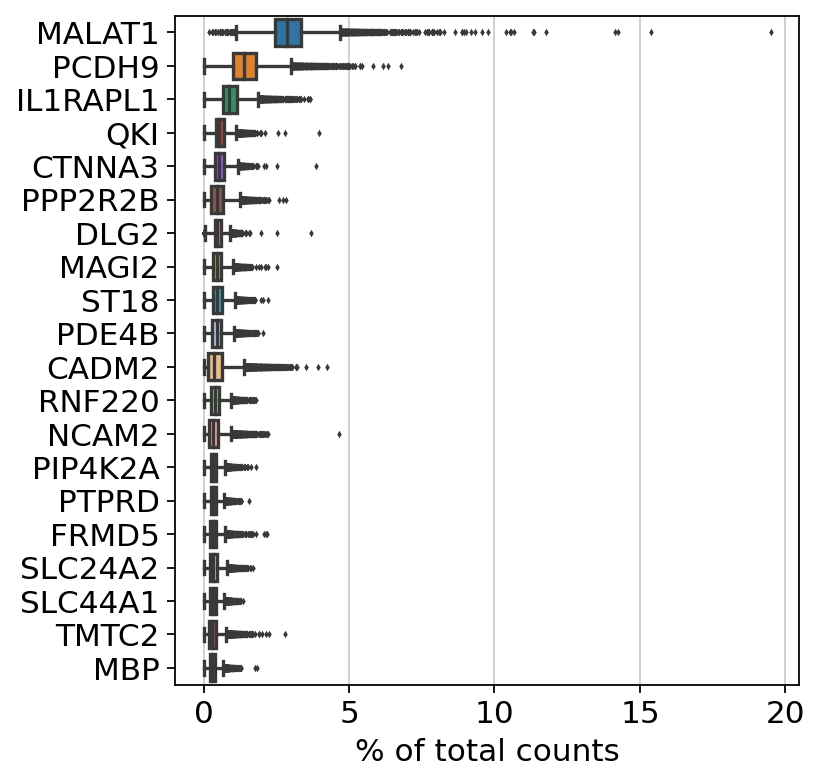

In [6]:
sc.pl.highest_expr_genes(adata, n_top=20, )

In [7]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

adata

AnnData object with n_obs × n_vars = 37052 × 30959
    obs: 'rna_barcode', 'Sample.ID', 'Batch', 'Sex', 'Age', 'Diagnosis', 'UMAP_1', 'UMAP_2', 'cluster', 'celltype', 'n_genes'
    var: 'n_cells'

In [8]:
sc.external.pp.scrublet(adata)

/data/leuven/338/vsc33838/miniconda3/envs/ibp-2022-env/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.77
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 1.6%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.2%


In [9]:
adata = adata[adata.obs['predicted_doublet'] == False] #do the actual filtering
adata

View of AnnData object with n_obs × n_vars = 37051 × 30959
    obs: 'rna_barcode', 'Sample.ID', 'Batch', 'Sex', 'Age', 'Diagnosis', 'UMAP_1', 'UMAP_2', 'cluster', 'celltype', 'n_genes', 'doublet_score', 'predicted_doublet'
    var: 'n_cells'
    uns: 'scrublet'

In [10]:
sum(adata.var_names.str.startswith('MT-'))

0

In [11]:
sc.pp.calculate_qc_metrics(adata, qc_vars=[], percent_top=None, log1p=False, inplace=True)
adata

/data/leuven/338/vsc33838/miniconda3/envs/ibp-2022-env/lib/python3.9/site-packages/scanpy/preprocessing/_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics


AnnData object with n_obs × n_vars = 37051 × 30959
    obs: 'rna_barcode', 'Sample.ID', 'Batch', 'Sex', 'Age', 'Diagnosis', 'UMAP_1', 'UMAP_2', 'cluster', 'celltype', 'n_genes', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'total_counts'
    var: 'n_cells', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'scrublet'

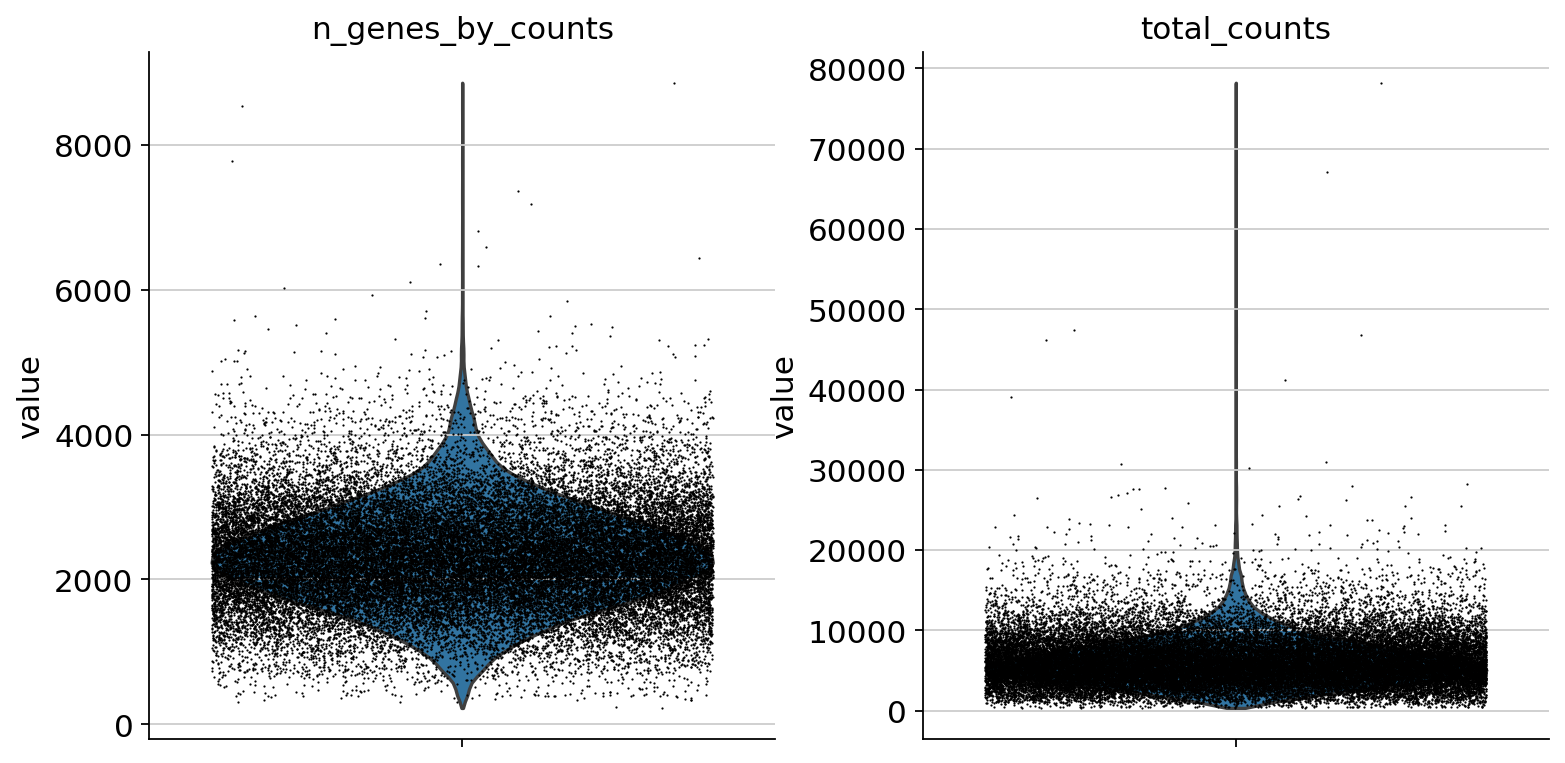

In [12]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts'],
             jitter=0.4, multi_panel=True)

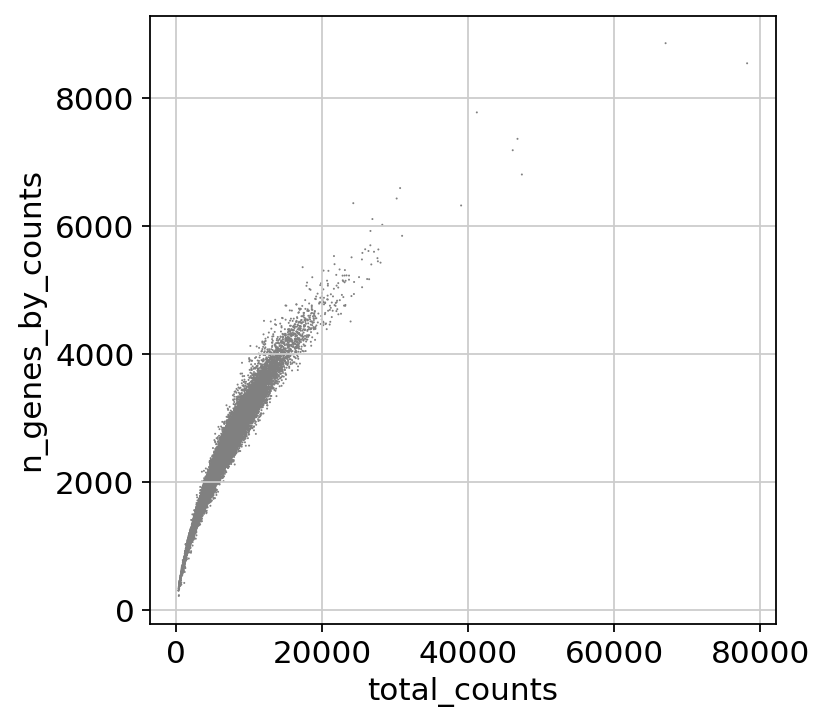

In [13]:
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [14]:
adata = adata[adata.obs.n_genes_by_counts < 3500, :]
adata

View of AnnData object with n_obs × n_vars = 35179 × 30959
    obs: 'rna_barcode', 'Sample.ID', 'Batch', 'Sex', 'Age', 'Diagnosis', 'UMAP_1', 'UMAP_2', 'cluster', 'celltype', 'n_genes', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'total_counts'
    var: 'n_cells', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'scrublet'

In [15]:
adata = adata[adata.obs.total_counts < 10000, :]
adata

View of AnnData object with n_obs × n_vars = 33401 × 30959
    obs: 'rna_barcode', 'Sample.ID', 'Batch', 'Sex', 'Age', 'Diagnosis', 'UMAP_1', 'UMAP_2', 'cluster', 'celltype', 'n_genes', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'total_counts'
    var: 'n_cells', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'scrublet'

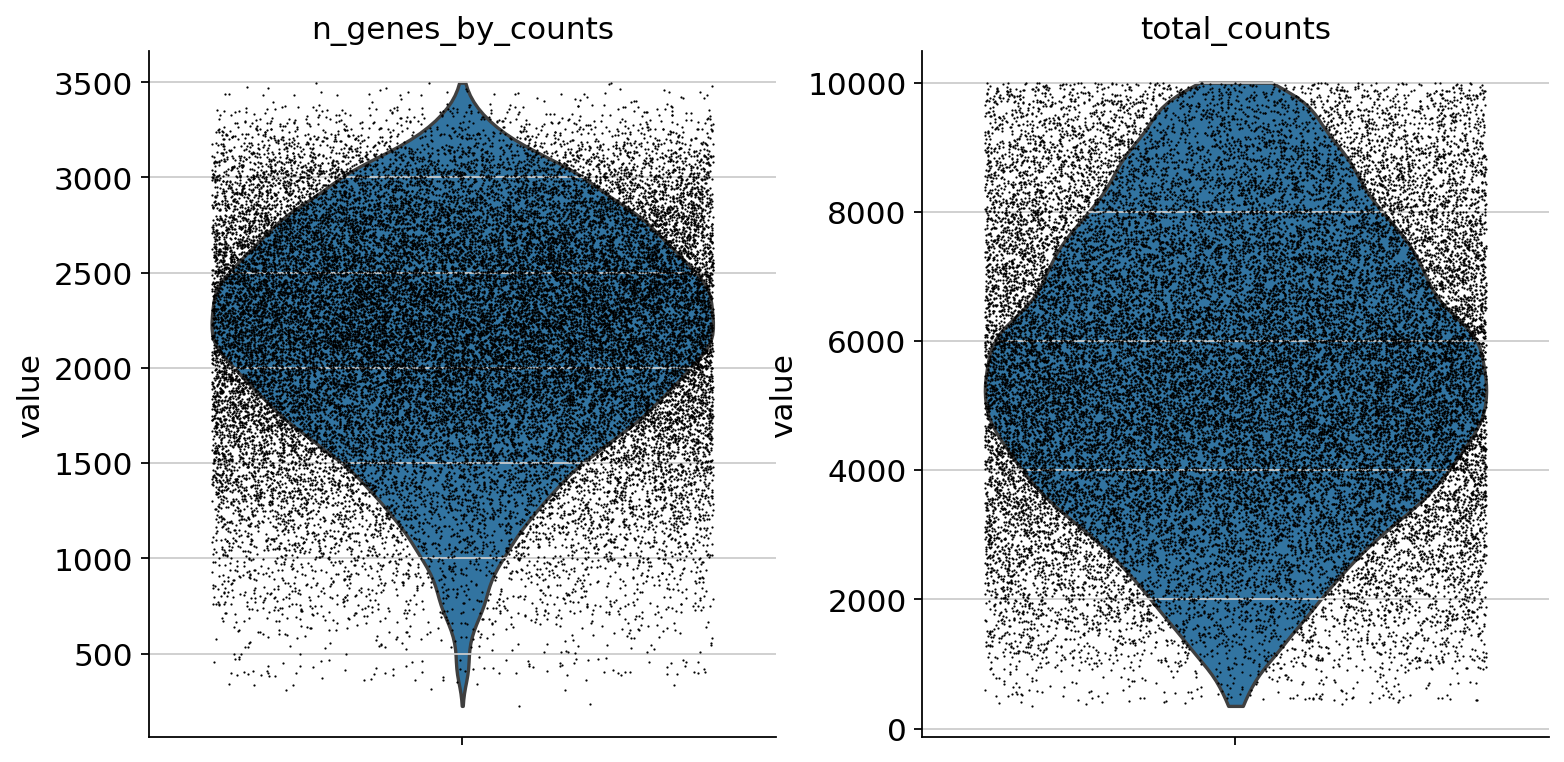

In [16]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts'],
             jitter=0.4, multi_panel=True)

# Data Normalization

In [17]:
adata.raw = adata
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

In [ ]:
adata.obs[

In [ ]:
adata = adata[:, adata.var.highly_variable]
sc.pp.regress_out(adata, ['total_counts', 'Batch', 'Sample.ID'])
sc.pp.scale(adata, max_value=10)
adata

In [ ]:
sc.pl.highest_expr_genes(adata, n_top=20, )

# PCA

In [20]:
sc.tl.pca(adata, svd_solver='arpack')

In [21]:
adata

AnnData object with n_obs × n_vars = 33401 × 3652
    obs: 'rna_barcode', 'Sample.ID', 'Batch', 'Sex', 'Age', 'Diagnosis', 'UMAP_1', 'UMAP_2', 'cluster', 'celltype', 'n_genes', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'total_counts'
    var: 'n_cells', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'scrublet', 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

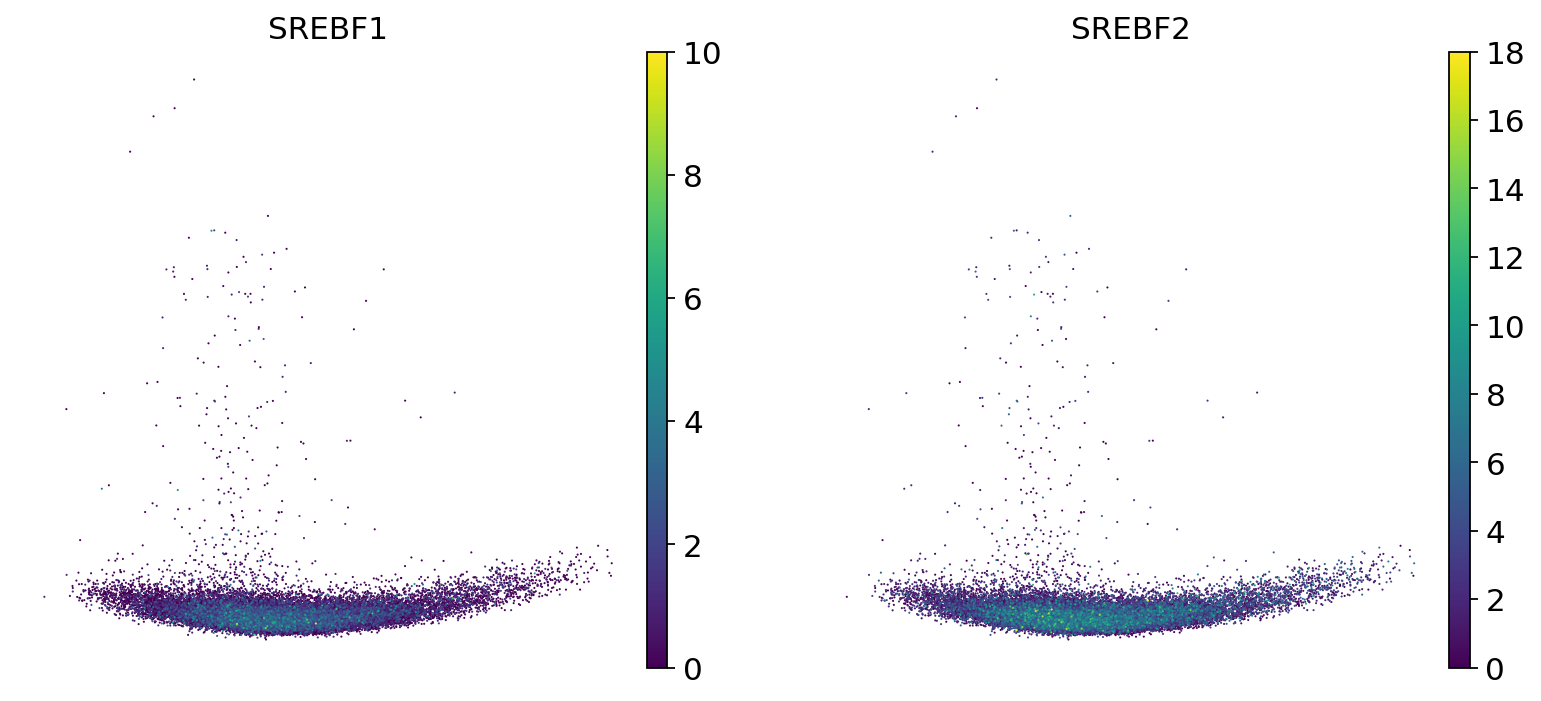

In [22]:
sc.pl.pca(adata, color=['SREBF1', 'SREBF2'])

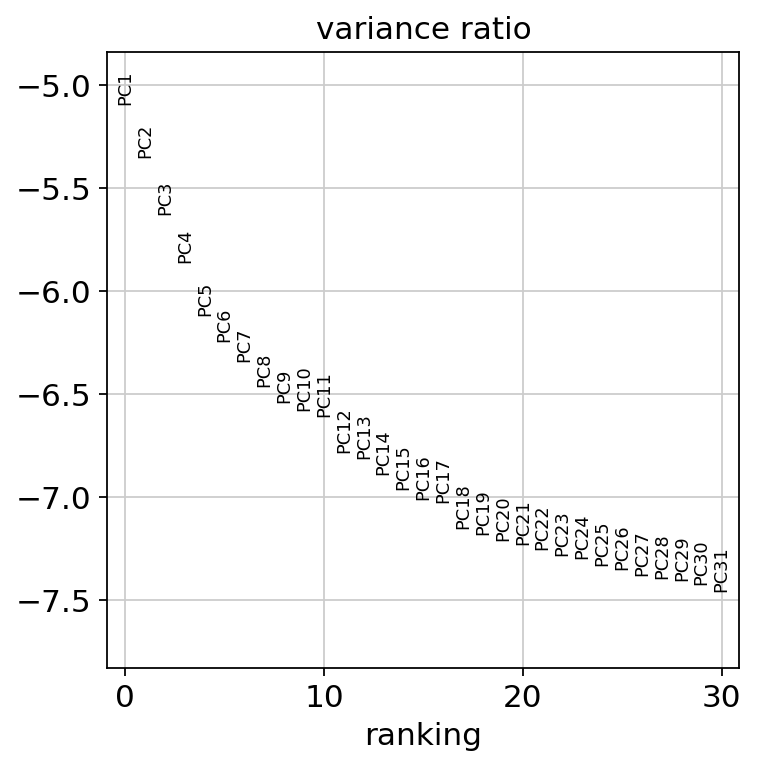

In [23]:
sc.pl.pca_variance_ratio(adata, log=True)

In [24]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)

/data/leuven/338/vsc33838/miniconda3/envs/ibp-2022-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


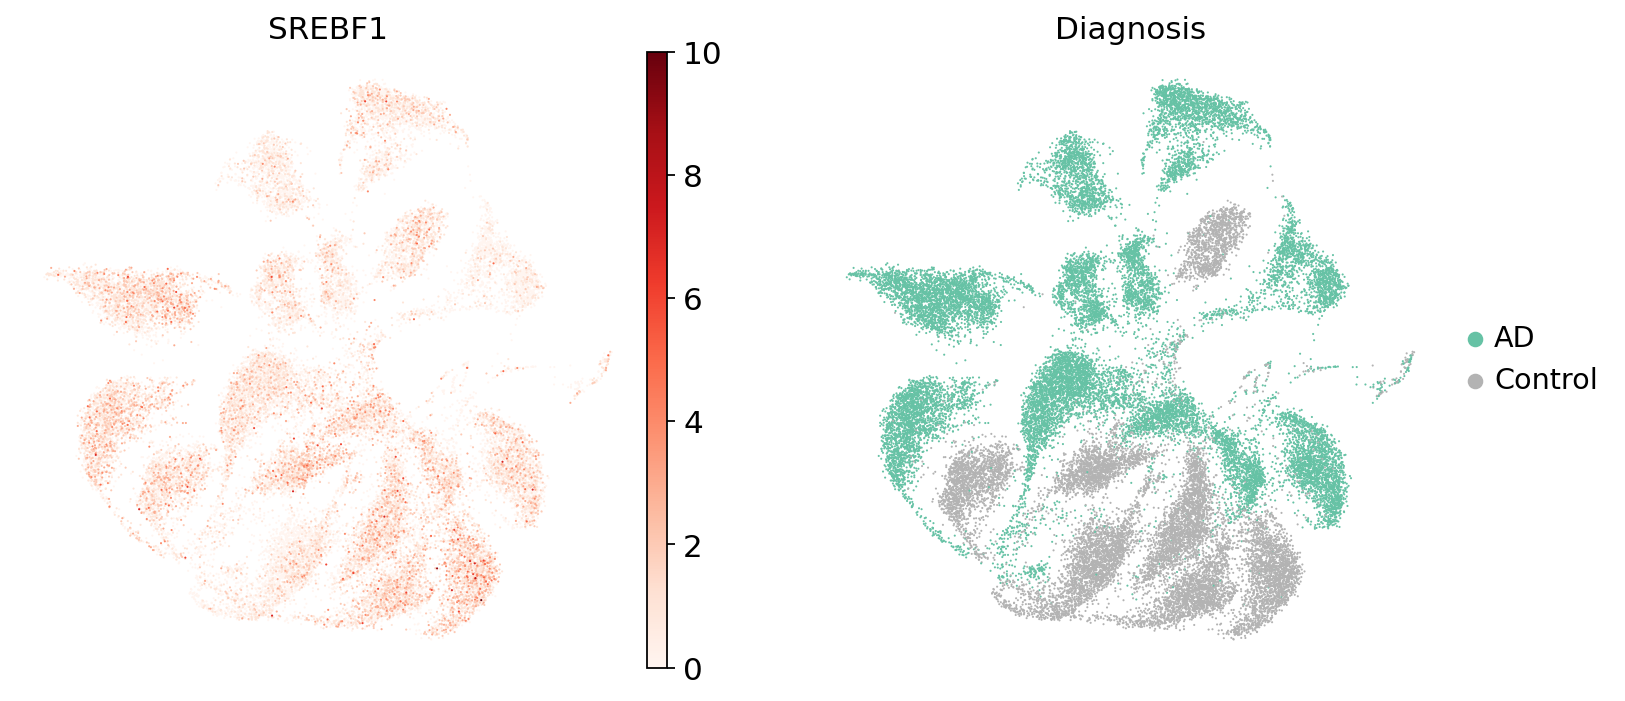

In [25]:
sc.pl.umap(adata, color=['SREBF1', 'Diagnosis'], palette="Set2", color_map=mpl.cm.Reds)

/data/leuven/338/vsc33838/miniconda3/envs/ibp-2022-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


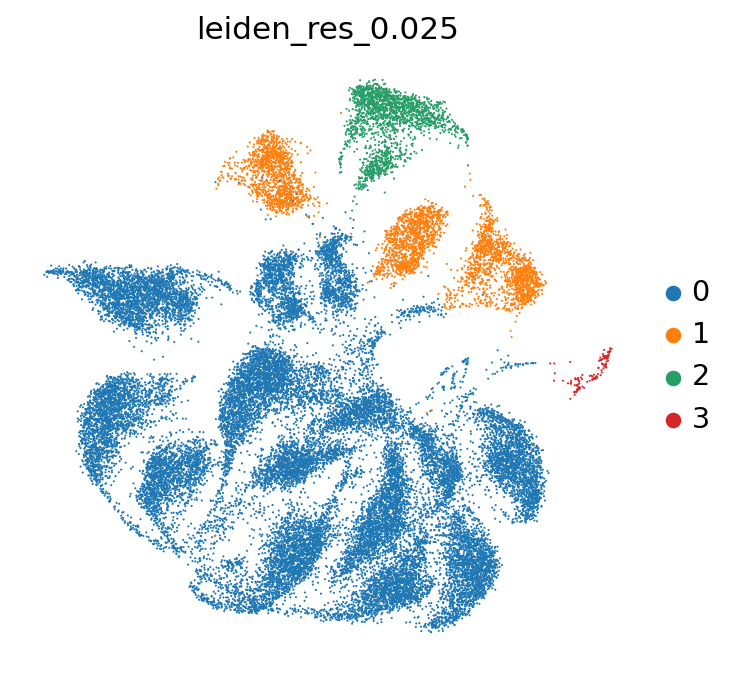

In [26]:
sc.tl.leiden(adata, resolution = 0.025, key_added = 'leiden_res_0.025')
sc.pl.umap(adata, color = 'leiden_res_0.025')

# Cell type annotation via metadata

/data/leuven/338/vsc33838/miniconda3/envs/ibp-2022-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/data/leuven/338/vsc33838/miniconda3/envs/ibp-2022-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/data/leuven/338/vsc33838/miniconda3/envs/ibp-2022-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


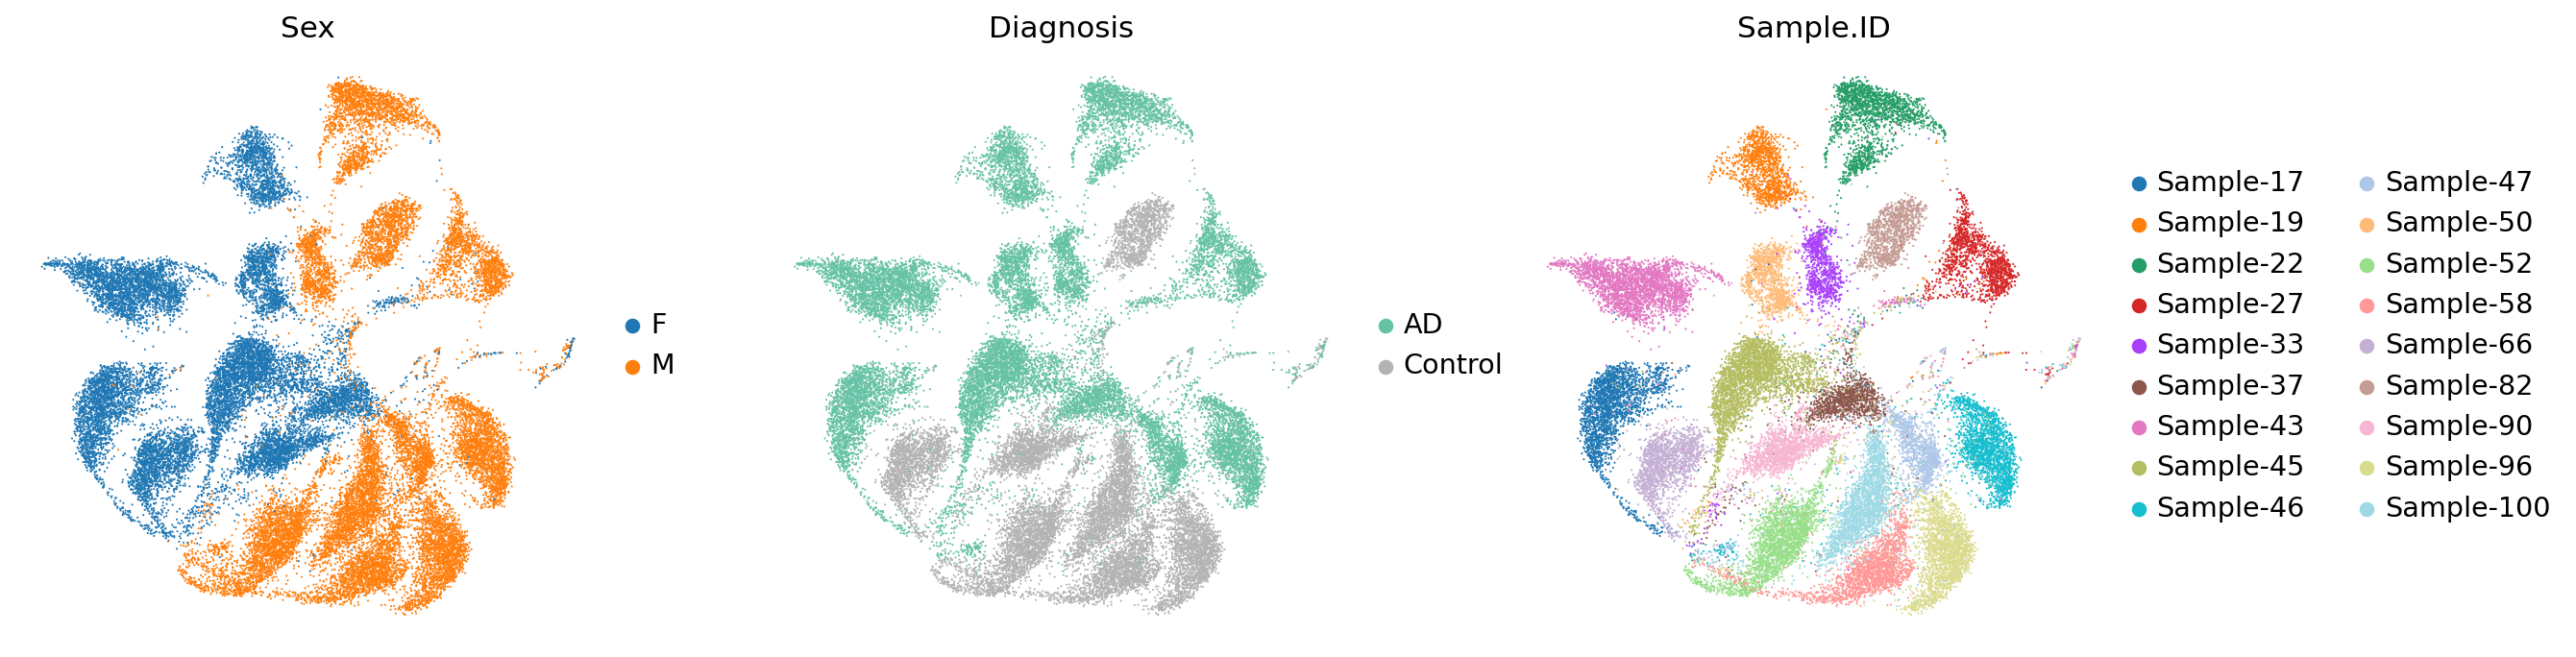

In [27]:
sc.pl.umap(adata, color=['Sex', 'Diagnosis', 'Sample.ID'])

/data/leuven/338/vsc33838/miniconda3/envs/ibp-2022-env/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/data/leuven/338/vsc33838/miniconda3/envs/ibp-2022-env/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


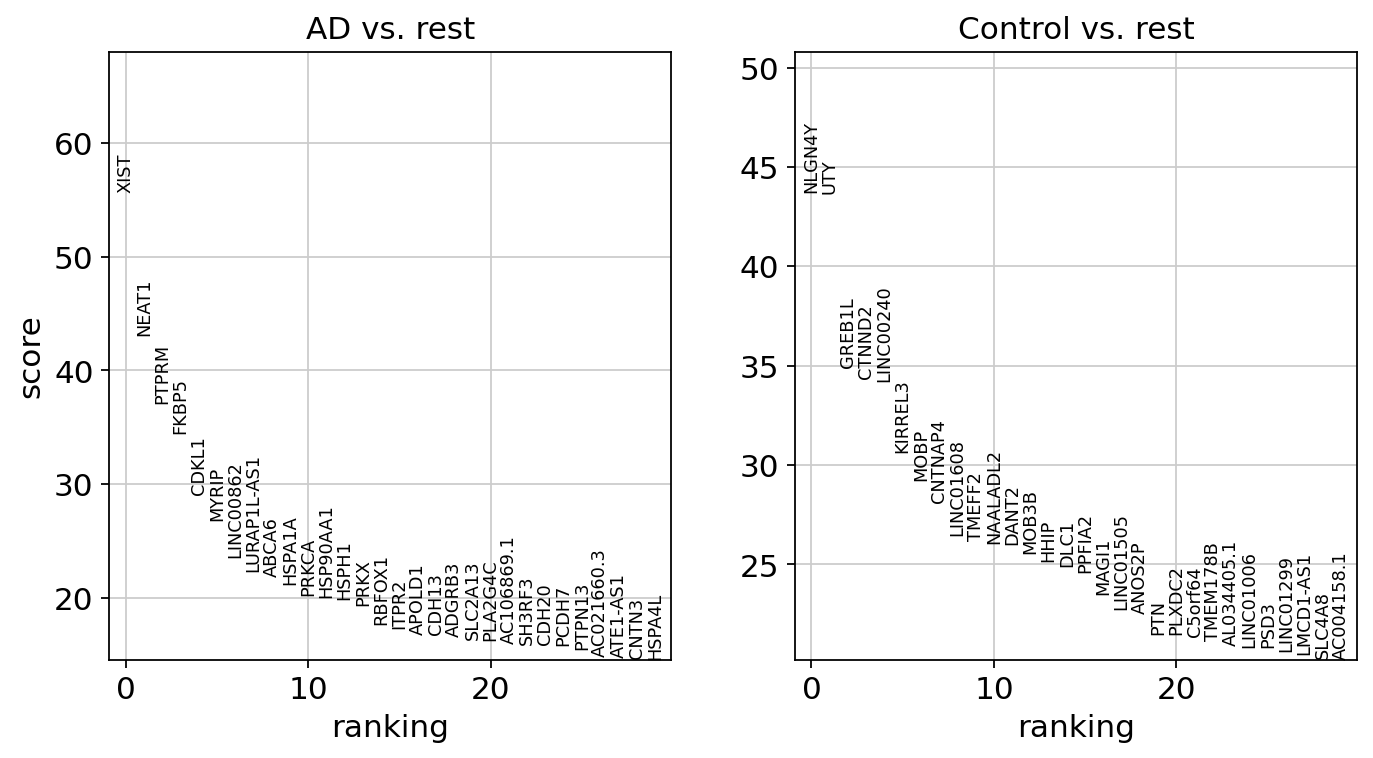

In [28]:
sc.tl.rank_genes_groups(adata, 'Diagnosis', method='wilcoxon', use_raw=False)
sc.pl.rank_genes_groups(adata, n_genes=30, sharey=False)

/data/leuven/338/vsc33838/miniconda3/envs/ibp-2022-env/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/data/leuven/338/vsc33838/miniconda3/envs/ibp-2022-env/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/data/leuven/338/vsc33838/miniconda3/envs/ibp-2022-env/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


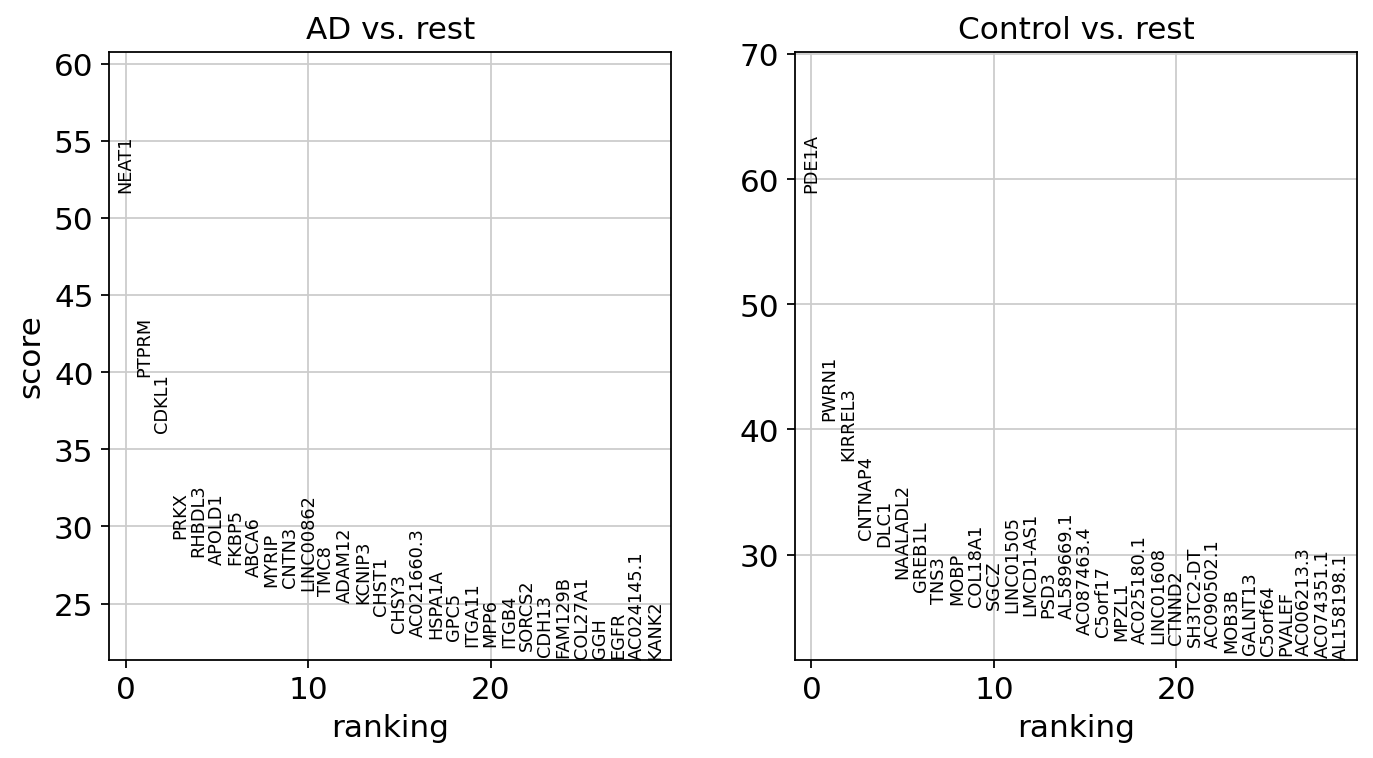

In [29]:
male_adata = adata[adata.obs.Sex == 'M',]

sc.tl.rank_genes_groups(male_adata, 'Diagnosis', method='wilcoxon', use_raw=False)
sc.pl.rank_genes_groups(male_adata, n_genes=30, sharey=False)

/data/leuven/338/vsc33838/miniconda3/envs/ibp-2022-env/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/data/leuven/338/vsc33838/miniconda3/envs/ibp-2022-env/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/data/leuven/338/vsc33838/miniconda3/envs/ibp-2022-env/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


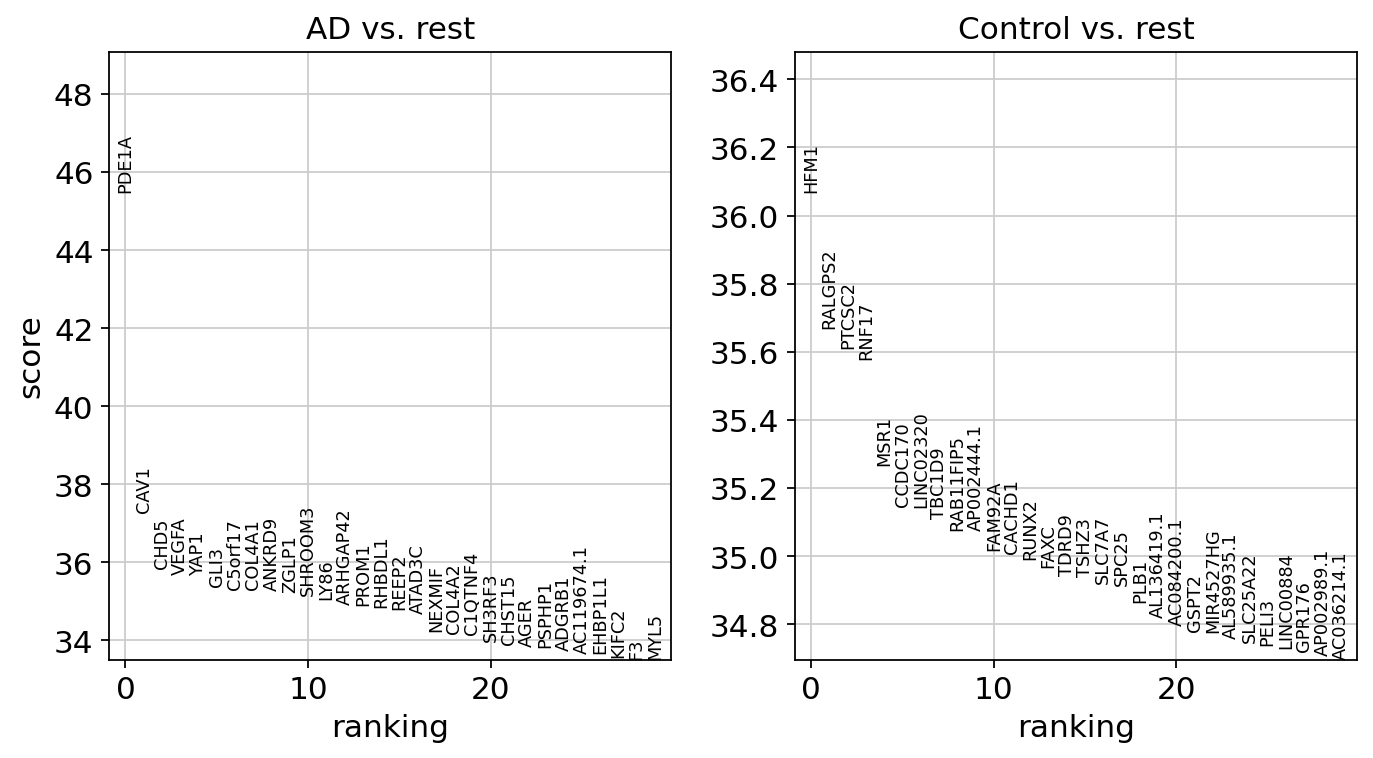

In [30]:
female_adata = adata[adata.obs.Sex == 'F',]

sc.tl.rank_genes_groups(female_adata, 'Diagnosis', method='wilcoxon', use_raw=False)
sc.pl.rank_genes_groups(female_adata, n_genes=30, sharey=False)

In [31]:
male_degs = set([g[0] for g in male_adata.uns['rank_genes_groups']['names'][0:10]])
female_degs = set([g[0] for g in female_adata.uns['rank_genes_groups']['names'][0:10]])
common_degs = male_degs & female_degs
common_degs

set()

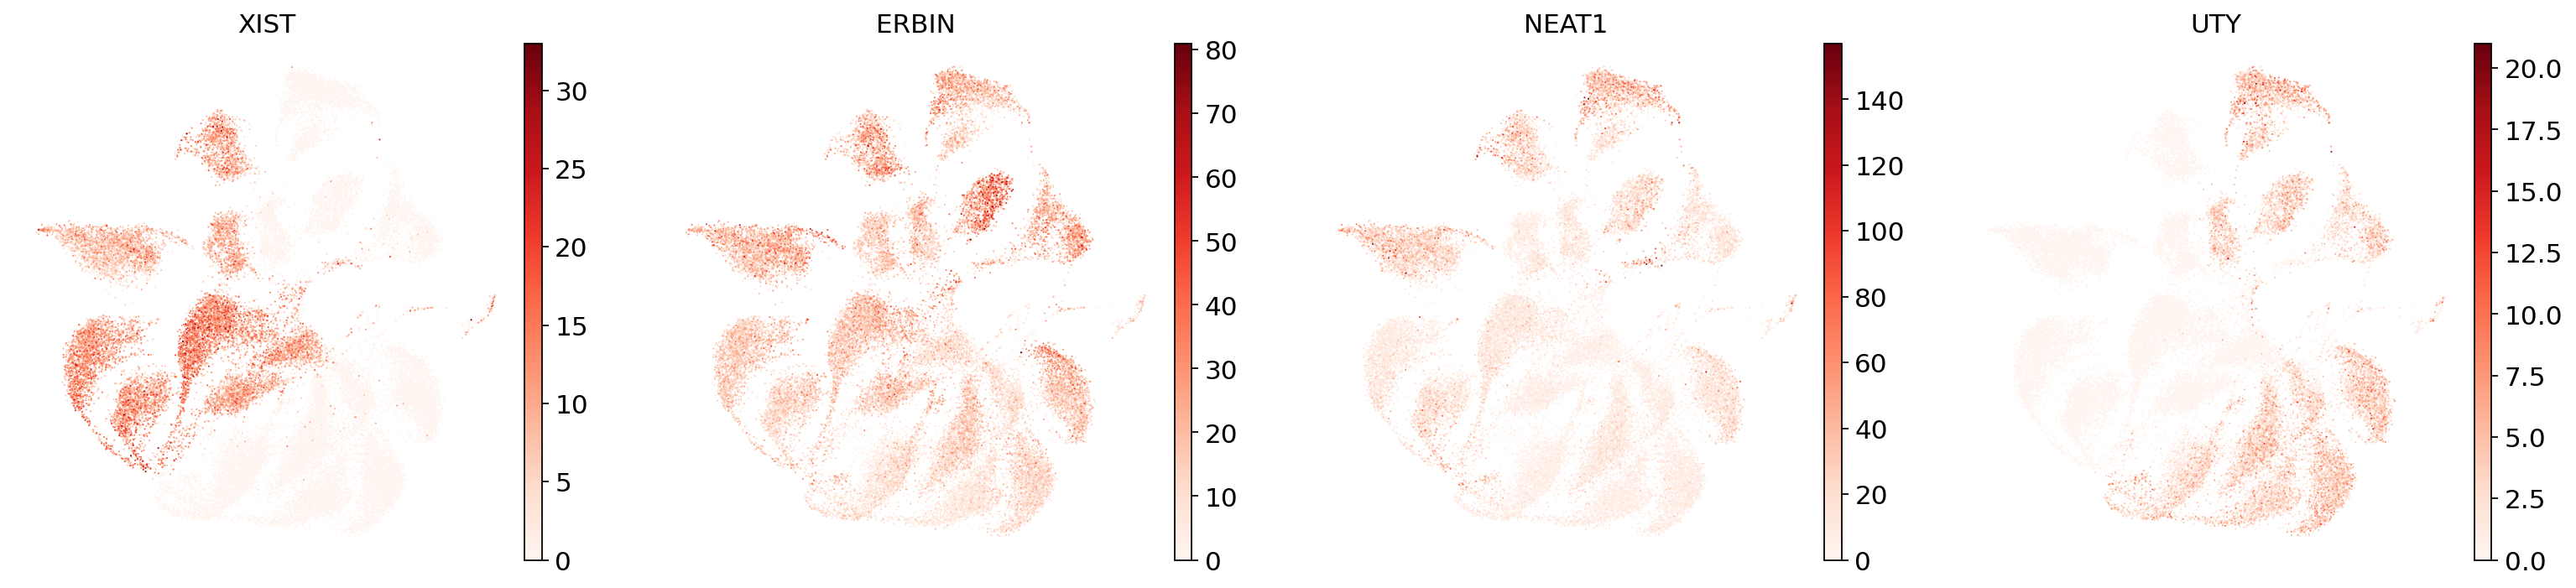

In [32]:
sc.pl.umap(adata, color=['XIST', 'ERBIN', 'NEAT1', 'UTY'], palette="Set2", color_map=mpl.cm.Reds)

# Saving the data

In [34]:
adata.raw.to_adata().write(os.path.join(mg_state, 'alzheimers.raw.h5ad'), compression='gzip')
adata.write(os.path.join(mg_state, 'alzheimers.h5ad'), compression='gzip') 

# Loading data

In [35]:
adata = sc.read_h5ad(os.path.join(mg_state, 'alzheimers.h5ad'))
adata.obs.head()

rna_barcode  Sample.ID  Batch Sex  Age Diagnosis  \
Unnamed: 0                                                                    
AAACCCAAGAAGCTCG-1  AAACCCAAGAAGCTCG-1  Sample-19      3   F   90        AD   
AAACCCAAGGATGCGT-1  AAACCCAAGGATGCGT-1  Sample-19      3   F   90        AD   
AAACGAAGTTCGAAGG-1  AAACGAAGTTCGAAGG-1  Sample-19      3   F   90        AD   
AAAGAACGTATTCCGA-1  AAAGAACGTATTCCGA-1  Sample-19      3   F   90        AD   
AAAGGATAGGCCTAAG-1  AAAGGATAGGCCTAAG-1  Sample-19      3   F   90        AD   

                      UMAP_1     UMAP_2 cluster celltype  n_genes  \
Unnamed: 0                                                          
AAACCCAAGAAGCTCG-1 -0.439007   8.746606    ODC9      ODC     2057   
AAACCCAAGGATGCGT-1  5.148611  11.073421    ODC7      ODC     3034   
AAACGAAGTTCGAAGG-1 -0.249035   6.647623    ODC1      ODC     1419   
AAAGAACGTATTCCGA-1 -1.294634   8.344845    ODC2      ODC     1334   
AAAGGATAGGCCTAAG-1 -0.349851  10.167821    ODC9      ODC     1528   

                    doublet_score  predicted_doublet  n_genes_by_counts  \
Unnamed: 0                                                                
AAACCCAAGAAGCTCG-1       0.048318              False               2057   
AAACCCAAGGATGCGT-1       0.026696              False               3034   
AAACGAAGTTCGAAGG-1       0.023973              False               1419   
AAAGAACGTATTCCGA-1       0.023021              False               1334   
AAAGGATAGGCCTAAG-1       0.018752              False               1528   

                    total_counts leiden_res_0.025  
Unnamed: 0                                         
AAACCCAAGAAGCTCG-1        4893.0                1  
AAACCCAAGGATGCGT-1        8986.0                1  
AAACGAAGTTCGAAGG-1        2561.0                1  
AAAGAACGTATTCCGA-1        2398.0                1  
AAAGGATAGGCCTAAG-1        3330.0                1

# ATAC-seq data

In [36]:
atac_metadata = pd.read_csv(os.path.join(atacseq_dir, 'snATAC_metadta.csv'), sep=',') #.iloc[:, -1].values
atac_metadata.index = atac_metadata.iloc[:,0]
atac_metadata = atac_metadata.rename(columns={'Unnamed: 0': 'barcode'})
atac_metadata['sample_id'] = 'alzheimers'
atac_metadata['celltype'] = atac_metadata['celltype'].astype(str)
atac_metadata

barcode   Sample.ID  Batch Sex  Age  \
Unnamed: 0                                                             
AAACGAAAGAAACGCC-13  AAACGAAAGAAACGCC-13   Sample-96      1   M   79   
AAACGAAAGAAATGGG-11  AAACGAAAGAAATGGG-11  Sample-101      2   F   74   
AAACGAAAGAAATGGG-5    AAACGAAAGAAATGGG-5   Sample-37      3   F   87   
AAACGAAAGAAATTCG-13  AAACGAAAGAAATTCG-13   Sample-96      1   M   79   
AAACGAAAGAACGACC-8    AAACGAAAGAACGACC-8   Sample-43      1   F   90   
...                                  ...         ...    ...  ..  ...   
TTTGTGTTCTTCATAC-13  TTTGTGTTCTTCATAC-13   Sample-96      1   M   79   
TTTGTGTTCTTCCACG-13  TTTGTGTTCTTCCACG-13   Sample-96      1   M   79   
TTTGTGTTCTTCCACG-7    TTTGTGTTCTTCCACG-7   Sample-46      2   M   90   
TTTGTGTTCTTGCGCT-1    TTTGTGTTCTTGCGCT-1   Sample-82      2   M   79   
TTTGTGTTCTTGCGCT-9    TTTGTGTTCTTGCGCT-9   Sample-47      3   M   90   

                    Diagnosis    UMAP_1    UMAP_2    cluster celltype  \
Unnamed: 0                                                              
AAACGAAAGAAACGCC-13   Control  4.653650 -2.973710      ODC.f      ODC   
AAACGAAAGAAATGGG-11   Control  6.781233 -2.420259      ODC.k      ODC   
AAACGAAAGAAATGGG-5         AD -2.631755 -6.038205  PER.END.a  PER.END   
AAACGAAAGAAATTCG-13   Control -7.145253  2.478923       EX.b       EX   
AAACGAAAGAACGACC-8         AD  3.383448  0.103595      ODC.a      ODC   
...                       ...       ...       ...        ...      ...   
TTTGTGTTCTTCATAC-13   Control  6.218156 -2.558979      ODC.j      ODC   
TTTGTGTTCTTCCACG-13   Control  4.888400 -5.111481      ODC.e      ODC   
TTTGTGTTCTTCCACG-7         AD  6.508900  0.919111      ODC.b      ODC   
TTTGTGTTCTTGCGCT-1    Control  5.296374 -4.003198      ODC.h      ODC   
TTTGTGTTCTTGCGCT-9         AD -7.266353 -9.165766       MG.a       MG   

                      sample_id  
Unnamed: 0                       
AAACGAAAGAAACGCC-13  alzheimers  
AAACGAAAGAAATGGG-11  alzheimers  
AAACGAAAGAAATGGG-5   alzheimers  
AAACGAAAGAAATTCG-13  alzheimers  
AAACGAAAGAACGACC-8   alzheimers  
...                         ...  
TTTGTGTTCTTCATAC-13  alzheimers  
TTTGTGTTCTTCCACG-13  alzheimers  
TTTGTGTTCTTCCACG-7   alzheimers  
TTTGTGTTCTTGCGCT-1   alzheimers  
TTTGTGTTCTTGCGCT-9   alzheimers  

[132623 rows x 11 columns]

In [37]:
atac_metadata = atac_metadata[atac_metadata.celltype == 'ODC']
pickle.dump(atac_metadata, open(os.path.join(mg_state, 'atac_metadata.pkl'), 'wb'))
atac_metadata

barcode   Sample.ID  Batch Sex  Age  \
Unnamed: 0                                                             
AAACGAAAGAAACGCC-13  AAACGAAAGAAACGCC-13   Sample-96      1   M   79   
AAACGAAAGAAATGGG-11  AAACGAAAGAAATGGG-11  Sample-101      2   F   74   
AAACGAAAGAACGACC-8    AAACGAAAGAACGACC-8   Sample-43      1   F   90   
AAACGAAAGACGACTG-6    AAACGAAAGACGACTG-6   Sample-90      3   F   79   
AAACGAAAGACTCGGA-7    AAACGAAAGACTCGGA-7   Sample-46      2   M   90   
...                                  ...         ...    ...  ..  ...   
TTTGTGTTCTTATCAC-6    TTTGTGTTCTTATCAC-6   Sample-90      3   F   79   
TTTGTGTTCTTCATAC-13  TTTGTGTTCTTCATAC-13   Sample-96      1   M   79   
TTTGTGTTCTTCCACG-13  TTTGTGTTCTTCCACG-13   Sample-96      1   M   79   
TTTGTGTTCTTCCACG-7    TTTGTGTTCTTCCACG-7   Sample-46      2   M   90   
TTTGTGTTCTTGCGCT-1    TTTGTGTTCTTGCGCT-1   Sample-82      2   M   79   

                    Diagnosis    UMAP_1    UMAP_2 cluster celltype   sample_id  
Unnamed: 0                                                                      
AAACGAAAGAAACGCC-13   Control  4.653650 -2.973710   ODC.f      ODC  alzheimers  
AAACGAAAGAAATGGG-11   Control  6.781233 -2.420259   ODC.k      ODC  alzheimers  
AAACGAAAGAACGACC-8         AD  3.383448  0.103595   ODC.a      ODC  alzheimers  
AAACGAAAGACGACTG-6    Control  4.592695 -1.605389   ODC.g      ODC  alzheimers  
AAACGAAAGACTCGGA-7         AD  6.289900  0.688146   ODC.b      ODC  alzheimers  
...                       ...       ...       ...     ...      ...         ...  
TTTGTGTTCTTATCAC-6    Control  3.612808 -3.429623   ODC.f      ODC  alzheimers  
TTTGTGTTCTTCATAC-13   Control  6.218156 -2.558979   ODC.j      ODC  alzheimers  
TTTGTGTTCTTCCACG-13   Control  4.888400 -5.111481   ODC.e      ODC  alzheimers  
TTTGTGTTCTTCCACG-7         AD  6.508900  0.919111   ODC.b      ODC  alzheimers  
TTTGTGTTCTTGCGCT-1    Control  5.296374 -4.003198   ODC.h      ODC  alzheimers  

[62259 rows x 11 columns]

In [38]:
fragments_dict = {'alzheimers': os.path.join(atacseq_dir, 'fragments.tsv.gz')}

In [39]:
# Get chromosome sizes (for hg38 here)
import pyranges as pr
import requests
import pandas as pd
target_url='http://hgdownload.cse.ucsc.edu/goldenPath/hg38/bigZips/hg38.chrom.sizes'
chromsizes=pd.read_csv(target_url, sep='\t', header=None)
chromsizes.columns=['Chromosome', 'End']
chromsizes['Start']=[0]*chromsizes.shape[0]
chromsizes=chromsizes.loc[:,['Chromosome', 'Start', 'End']]
# Exceptionally in this case, to agree with CellRangerARC annotations
chromsizes['Chromosome'] = [chromsizes['Chromosome'][x].replace('v', '.') for x in range(len(chromsizes['Chromosome']))]
chromsizes['Chromosome'] = [chromsizes['Chromosome'][x].split('_')[1] if len(chromsizes['Chromosome'][x].split('_')) > 1 else chromsizes['Chromosome'][x] for x in range(len(chromsizes['Chromosome']))]
chromsizes=pr.PyRanges(chromsizes)

In [40]:
from pycisTopic.pseudobulk_peak_calling import export_pseudobulk
bw_paths, bed_paths = export_pseudobulk(input_data = atac_metadata,
                 variable = 'Diagnosis',                                                                     # variable by which to generate pseubulk profiles, in this case we want pseudobulks per celltype
                 sample_id_col = 'sample_id',
                 chromsizes = chromsizes,
                 bed_path = os.path.join(mg_state, 'consensus_peak_calling/pseudobulk_bed_files/'),  # specify where pseudobulk_bed_files should be stored
                 bigwig_path = os.path.join(mg_state, 'consensus_peak_calling/pseudobulk_bw_files/'),# specify where pseudobulk_bw_files should be stored
                 path_to_fragments = fragments_dict,                                                        # location of fragment fiels
                 n_cpu = 30,                                                                                 # specify the number of cores to use, we use ray for multi processing
                 normalize_bigwig = True,
                 remove_duplicates = True,
                 _temp_dir = '/tmp/odc_rayspill',
                 use_polars = False,
                 split_pattern = '-')

2022-11-22 11:15:24,613 cisTopic     INFO     Reading fragments from /data/leuven/345/vsc34561/ibp-2022-data/sn_atac_seq/fragments.tsv.gz


2022-11-22 11:56:26,367	INFO worker.py:1509 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


(export_pseudobulk_ray pid=2738820) 2022-11-22 11:56:48,404 cisTopic     INFO     Creating pseudobulk for AD
(export_pseudobulk_ray pid=2738819) 2022-11-22 11:56:50,930 cisTopic     INFO     Creating pseudobulk for Control
(export_pseudobulk_ray pid=2738819) 2022-11-22 12:22:48,945 cisTopic     INFO     Control done!


In [41]:
import pickle
pickle.dump(bed_paths,
            open(os.path.join(mg_state, 'consensus_peak_calling/pseudobulk_bed_files/bed_paths.pkl'), 'wb'))
pickle.dump(bw_paths,
           open(os.path.join(mg_state, 'consensus_peak_calling/pseudobulk_bed_files/bw_paths.pkl'), 'wb'))

In [42]:
import pickle
bed_paths = pickle.load(open(os.path.join(mg_state, 'consensus_peak_calling/pseudobulk_bed_files/bed_paths.pkl'), 'rb'))
bw_paths =  pickle.load(open(os.path.join(mg_state, 'consensus_peak_calling/pseudobulk_bed_files/bw_paths.pkl'), 'rb'))

In [43]:
from pycisTopic.pseudobulk_peak_calling import peak_calling
macs_path='/data/leuven/338/vsc33838/miniconda3/envs/ibp-2022-env/bin/macs2'
# Run peak calling
narrow_peaks_dict = peak_calling(macs_path,
                                 bed_paths,
                                 os.path.join(mg_state, 'consensus_peak_calling/MACS/'),
                                 genome_size='hs',
                                 n_cpu=1,
                                 input_format='BEDPE',
                                 shift=73,
                                 ext_size=146,
                                 keep_dup = 'all',
                                 q_value = 0.05,
                                 _temp_dir = os.path.join(mg_state, 'mg_rayspill'))

2022-11-22 12:35:03,637 cisTopic     INFO     Calling peaks for AD with /data/leuven/338/vsc33838/miniconda3/envs/ibp-2022-env/bin/macs2 callpeak --treatment /scratch/leuven/338/vsc33838/odc_state/consensus_peak_calling/pseudobulk_bed_files/AD.bed.gz --name AD  --outdir /scratch/leuven/338/vsc33838/odc_state/consensus_peak_calling/MACS/ --format BEDPE --gsize hs --qvalue 0.05 --nomodel --shift 73 --extsize 146 --keep-dup all --call-summits --nolambda
2022-11-22 12:41:28,783 cisTopic     INFO     AD done!
2022-11-22 12:41:28,785 cisTopic     INFO     Calling peaks for Control with /data/leuven/338/vsc33838/miniconda3/envs/ibp-2022-env/bin/macs2 callpeak --treatment /scratch/leuven/338/vsc33838/odc_state/consensus_peak_calling/pseudobulk_bed_files/Control.bed.gz --name Control  --outdir /scratch/leuven/338/vsc33838/odc_state/consensus_peak_calling/MACS/ --format BEDPE --gsize hs --qvalue 0.05 --nomodel --shift 73 --extsize 146 --keep-dup all --call-summits --nolambda
2022-11-22 12:46:05,

In [44]:
narrow_peaks_dict

{'AD': +--------------+-----------+-----------+-----------------+-------+
 | Chromosome   | Start     | End       | Name            | +6    |
 | (category)   | (int32)   | (int32)   | (object)        | ...   |
 |--------------+-----------+-----------+-----------------+-------|
 | chr1         | 10067     | 10444     | AD_peak_1       | ...   |
 | chr1         | 190633    | 191927    | AD_peak_2a      | ...   |
 | chr1         | 190633    | 191927    | AD_peak_2b      | ...   |
 | chr1         | 190633    | 191927    | AD_peak_2c      | ...   |
 | ...          | ...       | ...       | ...             | ...   |
 | chrY         | 56870779  | 56871184  | AD_peak_147350  | ...   |
 | chrY         | 56873623  | 56874690  | AD_peak_147351a | ...   |
 | chrY         | 56873623  | 56874690  | AD_peak_147351b | ...   |
 | chrY         | 56873623  | 56874690  | AD_peak_147351c | ...   |
 +--------------+-----------+-----------+-----------------+-------+
 Unstranded PyRanges object has 319,864 ro

In [45]:
pickle.dump(narrow_peaks_dict,
            open(os.path.join(mg_state, 'consensus_peak_calling/MACS/narrow_peaks_dict.pkl'), 'wb'))

In [46]:
from pycisTopic.iterative_peak_calling import *
# Other param
peak_half_width = 250
path_to_blacklist= os.path.join(state_dir, 'hg38-blacklist.v2.bed')
# Get consensus peaks
consensus_peaks=get_consensus_peaks(narrow_peaks_dict, peak_half_width, chromsizes=chromsizes, path_to_blacklist=path_to_blacklist)

2022-11-22 12:46:06,156 cisTopic     INFO     Extending and merging peaks per class
2022-11-22 12:47:07,206 cisTopic     INFO     Normalizing peak scores
2022-11-22 12:47:07,386 cisTopic     INFO     Merging peaks
Warning! Start and End columns now have different dtypes: int64 and int32
2022-11-22 12:48:15,562 cisTopic     INFO     Done!


In [47]:
consensus_peaks.to_bed(
    path = os.path.join(mg_state, 'consensus_peak_calling/consensus_regions.bed'),
    keep=True,
    compression='infer',
    chain=False)

# ATAC-seq quality control

In [48]:
import pybiomart as pbm
dataset = pbm.Dataset(name='hsapiens_gene_ensembl',  host='http://www.ensembl.org')
annot = dataset.query(attributes=['chromosome_name', 'transcription_start_site', 'strand', 'external_gene_name', 'transcript_biotype'])
annot['Chromosome/scaffold name'] = annot['Chromosome/scaffold name'].to_numpy(dtype = str)
filter = annot['Chromosome/scaffold name'].str.contains('CHR|GL|JH|MT')
annot = annot[~filter]
annot['Chromosome/scaffold name'] = annot['Chromosome/scaffold name'].str.replace(r'(\b\S)', r'chr\1')
annot.columns=['Chromosome', 'Start', 'Strand', 'Gene', 'Transcript_type']
annot = annot[annot.Transcript_type == 'protein_coding']
from pycisTopic.qc import *
path_to_regions = {'alzheimers':os.path.join(mg_state, 'consensus_peak_calling/consensus_regions.bed')}

metadata_bc, profile_data_dict = compute_qc_stats(
                fragments_dict = fragments_dict,
                tss_annotation = annot,
                stats=['barcode_rank_plot', 'duplicate_rate', 'insert_size_distribution', 'profile_tss', 'frip'],
                label_list = None,
                path_to_regions = path_to_regions,
                n_cpu = 1,
                valid_bc = None,
                n_frag = 100,
                n_bc = None,
                tss_flank_window = 1000,
                tss_window = 50,
                tss_minimum_signal_window = 100,
                tss_rolling_window = 10,
                remove_duplicates = True,
                use_polars = False,
                _temp_dir = os.path.join(mg_state, 'mg_rayspill'))

if not os.path.exists(os.path.join(mg_state, 'quality_control')):
    os.makedirs(os.path.join(mg_state, 'quality_control'))

pickle.dump(metadata_bc,
            open(os.path.join(mg_state, 'quality_control/metadata_bc.pkl'), 'wb'))

pickle.dump(profile_data_dict,
            open(os.path.join(mg_state, 'quality_control/profile_data_dict.pkl'), 'wb'))

2022-11-22 12:48:18,273 cisTopic     INFO     Reading alzheimers
2022-11-22 13:31:34,988 cisTopic     INFO     Computing barcode rank plot for alzheimers
2022-11-22 13:31:34,991 cisTopic     INFO     Counting fragments
2022-11-22 13:32:52,283 cisTopic     INFO     Marking barcodes with more than 100
2022-11-22 13:32:52,625 cisTopic     INFO     Returning plot data
2022-11-22 13:32:52,887 cisTopic     INFO     Returning valid barcodes
2022-11-22 13:33:41,239 cisTopic     INFO     Computing duplicate rate plot for alzheimers
2022-11-22 13:35:30,134 cisTopic     INFO     Return plot data
2022-11-22 13:35:30,529 cisTopic     INFO     Computing insert size distribution for alzheimers
2022-11-22 13:35:30,530 cisTopic     INFO     Counting fragments
2022-11-22 13:35:48,871 cisTopic     INFO     Returning plot data
2022-11-22 13:41:41,346 cisTopic     INFO     Computing TSS profile for alzheimers
2022-11-22 13:44:03,455 cisTopic     INFO     Formatting annnotation
2022-11-22 13:44:03,541 cisTo

/data/leuven/338/vsc33838/miniconda3/envs/ibp-2022-env/lib/python3.9/site-packages/pycisTopic/qc.py:1871: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(
/data/leuven/338/vsc33838/miniconda3/envs/ibp-2022-env/lib/python3.9/site-packages/pycisTopic/qc.py:1886: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.

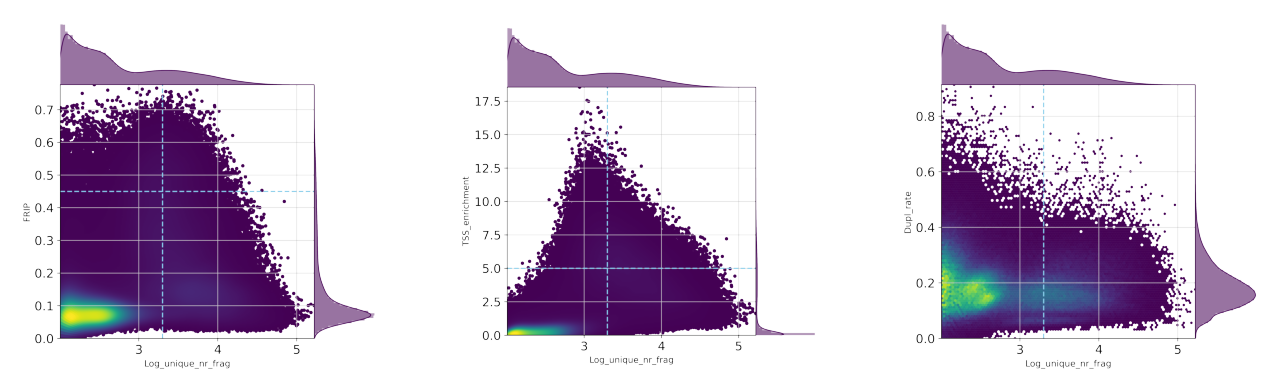

In [49]:
QC_filters = {
    'Log_unique_nr_frag': [3.3 , None],
    'FRIP':               [0.45, None],
    'TSS_enrichment':     [5   , None],
    'Dupl_rate':          [None, None]

}

# Return figure to plot together with other metrics, and cells passing filters. Figure will be saved as pdf.
from pycisTopic.qc import *
FRIP_NR_FRAG_fig, FRIP_NR_FRAG_filter=plot_barcode_metrics(metadata_bc['alzheimers'],
                                       var_x='Log_unique_nr_frag',
                                       var_y='FRIP',
                                       min_x=QC_filters['Log_unique_nr_frag'][0],
                                       max_x=QC_filters['Log_unique_nr_frag'][1],
                                       min_y=QC_filters['FRIP'][0],
                                       max_y=QC_filters['FRIP'][1],
                                       return_cells=True,
                                       return_fig=True,
                                       plot=False)
# Return figure to plot together with other metrics, and cells passing filters
TSS_NR_FRAG_fig, TSS_NR_FRAG_filter=plot_barcode_metrics(metadata_bc['alzheimers'],
                                      var_x='Log_unique_nr_frag',
                                      var_y='TSS_enrichment',
                                      min_x=QC_filters['Log_unique_nr_frag'][0],
                                      max_x=QC_filters['Log_unique_nr_frag'][1],
                                      min_y=QC_filters['TSS_enrichment'][0],
                                      max_y=QC_filters['TSS_enrichment'][1],
                                      return_cells=True,
                                      return_fig=True,
                                      plot=False)
# Return figure to plot together with other metrics, but not returning cells (no filter applied for the duplication rate  per barcode)
DR_NR_FRAG_fig=plot_barcode_metrics(metadata_bc['alzheimers'],
                                      var_x='Log_unique_nr_frag',
                                      var_y='Dupl_rate',
                                      min_x=QC_filters['Log_unique_nr_frag'][0],
                                      max_x=QC_filters['Log_unique_nr_frag'][1],
                                      min_y=QC_filters['Dupl_rate'][0],
                                      max_y=QC_filters['Dupl_rate'][1],
                                      return_cells=False,
                                      return_fig=True,
                                      plot=False,
                                      plot_as_hexbin = True)

# Plot barcode stats in one figure
fig=plt.figure(figsize=(10,10))
plt.subplot(1, 3, 1)
img = fig2img(FRIP_NR_FRAG_fig)
plt.imshow(img)
plt.axis('off')
plt.subplot(1, 3, 2)
img = fig2img(TSS_NR_FRAG_fig)
plt.imshow(img)
plt.axis('off')
plt.subplot(1, 3, 3)
img = fig2img(DR_NR_FRAG_fig)
plt.imshow(img)
plt.axis('off')
plt.show()

In [50]:
bc_passing_filters = {'alzheimers':[]}
bc_passing_filters['alzheimers'] = list((set(FRIP_NR_FRAG_filter) & set(TSS_NR_FRAG_filter)))
pickle.dump(bc_passing_filters, open(os.path.join(mg_state, 'quality_control/bc_passing_filters.pkl'), 'wb'))
print(f"{len(bc_passing_filters['alzheimers'])} barcodes passed QC stats")

9909 barcodes passed QC stats


# Checkpoint load

In [ ]:
# Load if needed

fragments_dict = {'alzheimers': os.path.join(atacseq_dir, 'fragments.tsv.gz')}
adata = sc.read_h5ad(os.path.join(mg_state, 'alzheimers.h5ad'))
path_to_regions = {'alzheimers':os.path.join(mg_state, 'consensus_peak_calling/consensus_regions.bed')}
path_to_blacklist= os.path.join(state_dir, 'hg38-blacklist.v2.bed')
metadata_bc = pickle.load(open(os.path.join(mg_state, 'quality_control/metadata_bc.pkl'), 'rb'))
bc_passing_filters = pickle.load(open(os.path.join(mg_state, 'quality_control/bc_passing_filters.pkl'), 'rb'))
atac_metadata = pickle.load(open(os.path.join(mg_state, 'atac_metadata.pkl'), 'rb'))



In [51]:
cell_data = adata.obs
cell_data['sample_id'] = 'alzheimers'
cell_data['celltype'] = cell_data['celltype'].astype(str)

# Topic Modelling

In [52]:
metadata_bc['alzheimers']

Log_total_nr_frag  Log_unique_nr_frag  Total_nr_frag  \
ACTTTCACAAGCAACG-13           3.930185            3.900586           8515   
AGGACGAGTGGACAGT-14           3.626853            3.573684           4235   
TAATTCCAGAACTCCT-14           3.472464            3.418301           2968   
TCCCACACAACTACTG-14           3.621799            3.567026           4186   
CAGCTAAAGGGTCCCT-14           3.980458            3.929061           9560   
...                                ...                 ...            ...   
TCGCAGGAGACACTTC-8            2.110590            2.056905            129   
ACAATCGAGCGTCAAG-12           2.139879            2.037426            138   
CTTAATCGTAACGGCA-20           2.252853            2.045323            179   
GTCACCTCAGAGATGC-14           2.158362            2.071882            144   
GCCCGAATCTTCATAC-6            2.357935            2.264818            228   

                     Unique_nr_frag  Dupl_nr_frag  Dupl_rate  \
ACTTTCACAAGCAACG-13            7954           561   0.065884   
AGGACGAGTGGACAGT-14            3747           488   0.115230   
TAATTCCAGAACTCCT-14            2620           348   0.117251   
TCCCACACAACTACTG-14            3690           496   0.118490   
CAGCTAAAGGGTCCCT-14            8493          1067   0.111611   
...                             ...           ...        ...   
TCGCAGGAGACACTTC-8              114            15   0.116279   
ACAATCGAGCGTCAAG-12             109            29   0.210145   
CTTAATCGTAACGGCA-20             111            68   0.379888   
GTCACCTCAGAGATGC-14             118            26   0.180556   
GCCCGAATCTTCATAC-6              184            44   0.192982   

                     Total_nr_frag_in_regions  Unique_nr_frag_in_regions  \
ACTTTCACAAGCAACG-13                      1064                        978   
AGGACGAGTGGACAGT-14                      2580                       2284   
TAATTCCAGAACTCCT-14                      1483                       1297   
TCCCACACAACTACTG-14                      1997                       1767   
CAGCTAAAGGGTCCCT-14                      2920                       2574   
...                                       ...                        ...   
TCGCAGGAGACACTTC-8                         13                         11   
ACAATCGAGCGTCAAG-12                        12                         10   
CTTAATCGTAACGGCA-20                        15                         13   
GTCACCTCAGAGATGC-14                         4                          3   
GCCCGAATCTTCATAC-6                         19                         13   

                         FRIP  TSS_enrichment  
ACTTTCACAAGCAACG-13  0.122957        2.518127  
AGGACGAGTGGACAGT-14  0.609554        5.597534  
TAATTCCAGAACTCCT-14  0.495038        5.288406  
TCCCACACAACTACTG-14  0.478862        6.094288  
CAGCTAAAGGGTCCCT-14  0.303073        3.671378  
...                       ...             ...  
TCGCAGGAGACACTTC-8   0.096491        0.155000  
ACAATCGAGCGTCAAG-12  0.091743        0.000000  
CTTAATCGTAACGGCA-20  0.117117        0.000000  
GTCACCTCAGAGATGC-14  0.025424        0.050000  
GCCCGAATCTTCATAC-6   0.070652        0.415000  

[544968 rows x 10 columns]

In [53]:
from pycisTopic.cistopic_class import *

key = 'alzheimers'
cistopic_obj = create_cistopic_object_from_fragments(
                            path_to_fragments=fragments_dict[key],
                            path_to_regions=path_to_regions[key],
                            path_to_blacklist=path_to_blacklist,
                            metrics=metadata_bc[key],
                            valid_bc=list(set(bc_passing_filters[key])),
                            n_cpu=30,
                            project=key,
                            split_pattern='-')


2022-11-22 17:25:41,532 cisTopic     INFO     Reading data for alzheimers
2022-11-22 17:43:06,498 cisTopic     INFO     metrics provided!
2022-11-22 17:44:21,966 cisTopic     INFO     valid_bc provided, selecting barcodes!
2022-11-22 17:44:57,616 cisTopic     INFO     Counting fragments in regions


2022-11-22 17:45:14,898	INFO worker.py:1509 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


2022-11-22 17:48:40,052 cisTopic     INFO     Creating fragment matrix


/data/leuven/338/vsc33838/miniconda3/envs/ibp-2022-env/lib/python3.9/site-packages/pycisTopic/cistopic_class.py:881: PerformanceWarning: The following operation may generate 2734775001 cells in the resulting pandas object.
  counts_df.groupby(["Name", "regionID"], sort=False, observed=True)


2022-11-22 17:49:12,253 cisTopic     INFO     Converting fragment matrix to sparse matrix
2022-11-22 17:49:24,830 cisTopic     INFO     Removing blacklisted regions
2022-11-22 17:49:25,940 cisTopic     INFO     Creating CistopicObject
2022-11-22 17:49:27,064 cisTopic     INFO     Done!


In [54]:
models=run_cgs_models(cistopic_obj,
                    n_topics=[2,4,6,10,16,20,22,24],
                    n_cpu=8,
                    n_iter=500,
                    random_state=555,
                    alpha=50,
                    alpha_by_topic=True,
                    eta=0.1,
                    eta_by_topic=False,
                    save_path=None,
                    _temp_dir = '/tmp/rayspill')

2022-11-22 17:49:57,076	INFO worker.py:1509 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


(run_cgs_model pid=2783533) 2022-11-22 17:50:10,387 cisTopic     INFO     Running model with 6 topics
(run_cgs_model pid=2783538) 2022-11-22 17:50:10,376 cisTopic     INFO     Running model with 2 topics
(run_cgs_model pid=2783540) 2022-11-22 17:50:10,375 cisTopic     INFO     Running model with 4 topics
(run_cgs_model pid=2783536) 2022-11-22 17:50:10,584 cisTopic     INFO     Running model with 10 topics
(run_cgs_model pid=2783539) 2022-11-22 17:50:10,615 cisTopic     INFO     Running model with 16 topics
(run_cgs_model pid=2783537) 2022-11-22 17:50:10,685 cisTopic     INFO     Running model with 20 topics
(run_cgs_model pid=2783534) 2022-11-22 17:50:10,769 cisTopic     INFO     Running model with 24 topics
(run_cgs_model pid=2783535) 2022-11-22 17:50:10,757 cisTopic     INFO     Running model with 22 topics
(run_cgs_model pid=2783538) 2022-11-22 18:00:43,286 cisTopic     INFO     Model with 2 topics done!
(run_cgs_model pid=2783540) 2022-11-22 18:06:23,382 cisTopic     INFO     Model

In [55]:
if not os.path.exists(os.path.join(mg_state, 'models')):
    os.makedirs(os.path.join(mg_state, 'models'))

pickle.dump(models, open(os.path.join(mg_state, 'models/alzheimers_topics.pkl'), 'wb'))

In [ ]:
models = pickle.load(open(os.path.join(mg_state, 'models/alzheimers_topics.pkl'), 'rb'))

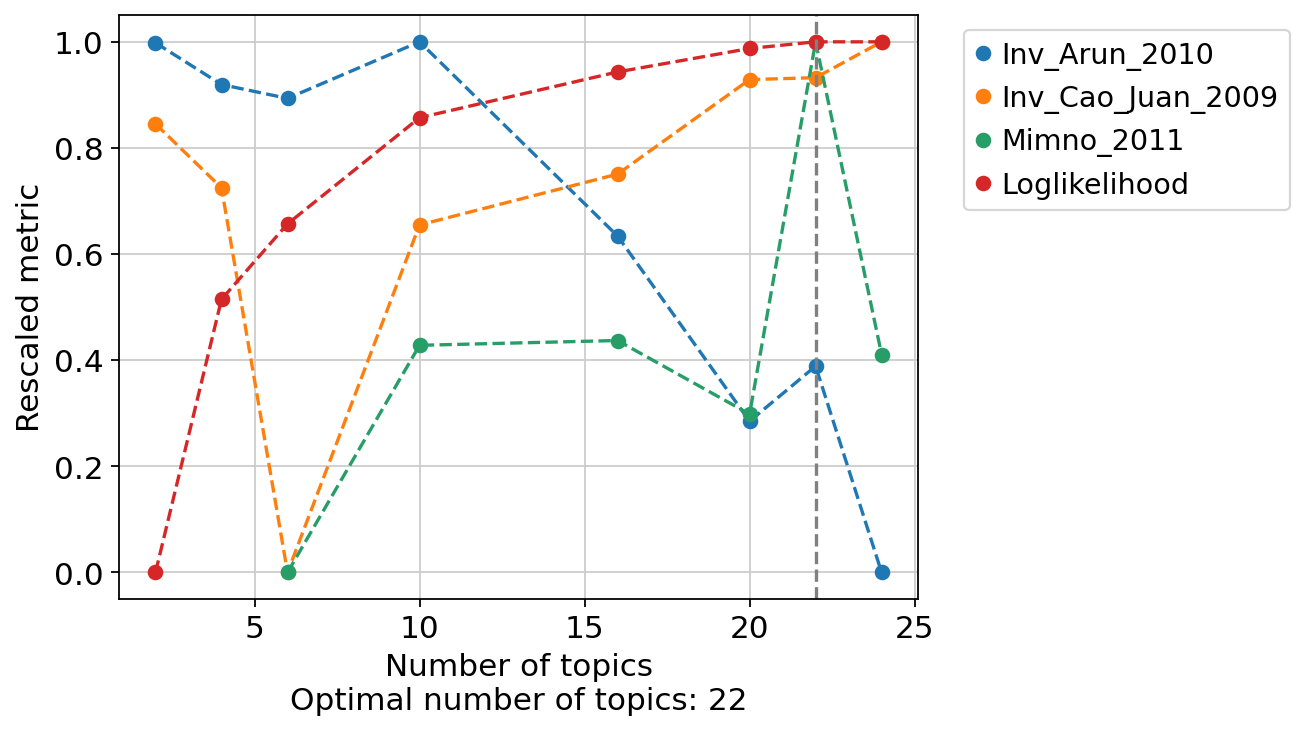

In [57]:
from pycisTopic.lda_models import *
model = evaluate_models(models,
                       select_model=22,
                       return_model=True,
                       metrics=['Arun_2010','Cao_Juan_2009', 'Minmo_2011', 'loglikelihood'],
                       plot_metrics=False)

In [58]:
cistopic_obj.add_cell_data(atac_metadata, split_pattern='-')
cistopic_obj.add_LDA_model(model)

pickle.dump(cistopic_obj, open(os.path.join(mg_state, 'cistopic_obj.pkl'), 'wb'))

Columns ['barcode', 'sample_id'] will be overwritten


# Visualization of topic modelling

In [ ]:
cistopic_obj = pickle.load(open(os.path.join(mg_state, 'cistopic_obj.pkl'), 'rb'))

In [59]:
from pycisTopic.clust_vis import *
run_umap(cistopic_obj, target  = 'cell', scale=True)

2022-11-22 19:15:52,180 cisTopic     INFO     Running UMAP


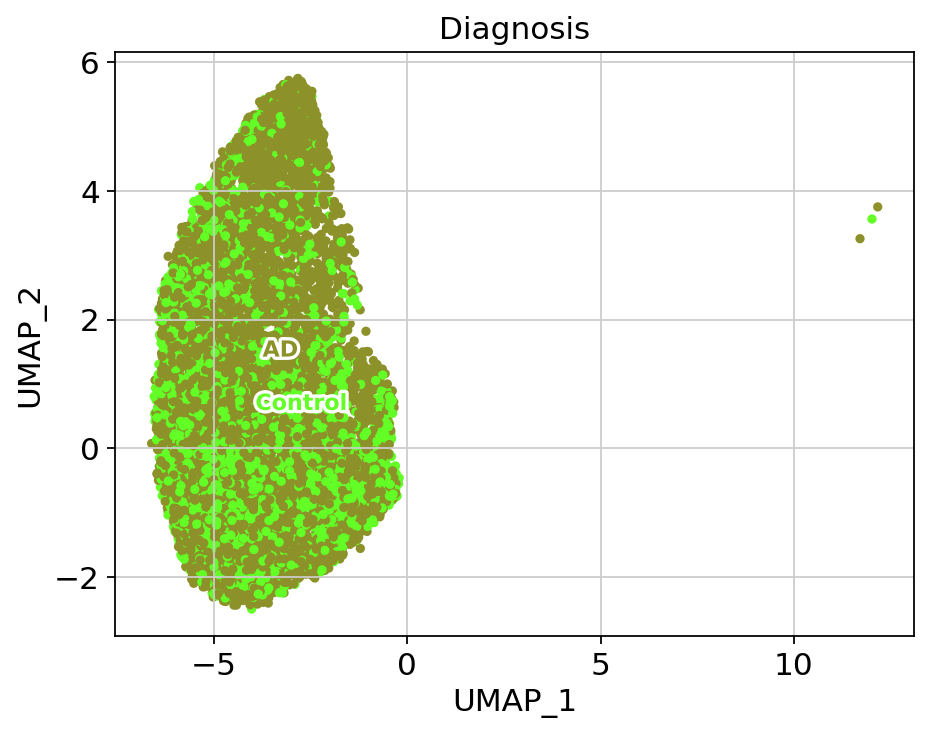

In [60]:
plot_metadata(cistopic_obj, reduction_name = 'UMAP', variables = ['Diagnosis'])

Here we do the same plot using the UMAP coordinates in the metadata.

In [62]:
cmap = {'AD': 'red', 
        'Control': 'green'}

na_mask = cistopic_obj.cell_data['Diagnosis'].isna() == False

for diag in cmap.keys():
    cmask = (cistopic_obj.cell_data['Diagnosis'] == diag) & na_mask
    mpl.pyplot.scatter(cistopic_obj.cell_data[cmask]['UMAP_1'].values, 
                    cistopic_obj.cell_data[cmask]['UMAP_2'].values,
                    label=diag,
                    color=cmap[diag])
mpl.pyplot.legend()

In [ ]:
plot_topic(cistopic_obj, reduction_name = 'UMAP', num_columns = 3)

# Inferring candidate enhancer regions

In [68]:
from pycisTopic.topic_binarization import *
region_bin_topics_otsu = binarize_topics(cistopic_obj, method='otsu')
region_bin_topics_top3k = binarize_topics(cistopic_obj, method='ntop', ntop = 3000)

In [69]:
from pycisTopic.diff_features import *
imputed_acc_obj = impute_accessibility(cistopic_obj, selected_cells=None, selected_regions=None, scale_factor=10**6)
normalized_imputed_acc_obj = normalize_scores(imputed_acc_obj, scale_factor=10**4)
variable_regions = find_highly_variable_features(normalized_imputed_acc_obj, plot = False)
markers_dict = find_diff_features(cistopic_obj, imputed_acc_obj, variable='Diagnosis', var_features=variable_regions, split_pattern = '-')

2022-11-22 19:23:53,444 cisTopic     INFO     Imputing drop-outs
2022-11-22 19:23:57,305 cisTopic     INFO     Scaling
2022-11-22 19:24:02,796 cisTopic     INFO     Keep non zero rows
2022-11-22 19:24:09,215 cisTopic     INFO     Imputed accessibility sparsity: 0.2982814029536788
2022-11-22 19:24:09,217 cisTopic     INFO     Create CistopicImputedFeatures object
2022-11-22 19:24:09,218 cisTopic     INFO     Done!
2022-11-22 19:24:09,240 cisTopic     INFO     Normalizing imputed data
2022-11-22 19:24:31,490 cisTopic     INFO     Done!
2022-11-22 19:24:31,537 cisTopic     INFO     Calculating mean
2022-11-22 19:24:34,150 cisTopic     INFO     Calculating variance
2022-11-22 19:24:51,548 cisTopic     INFO     Done!
2022-11-22 19:24:53,709 cisTopic     INFO     Formatting data for AD
2022-11-22 19:25:00,110 cisTopic     INFO     Computing p-value for AD
2022-11-22 19:26:06,286 cisTopic     INFO     Computing log2FC for AD
2022-11-22 19:26:07,791 cisTopic     INFO     AD done!
2022-11-22 19

In [70]:
if not os.path.exists(os.path.join(mg_state, 'candidate_enhancers')):
    os.makedirs(os.path.join(mg_state, 'candidate_enhancers'))

pickle.dump(region_bin_topics_otsu, open(os.path.join(mg_state, 'candidate_enhancers/region_bin_topics_otsu.pkl'), 'wb'))
pickle.dump(region_bin_topics_top3k, open(os.path.join(mg_state, 'candidate_enhancers/region_bin_topics_top3k.pkl'), 'wb'))
pickle.dump(markers_dict, open(os.path.join(mg_state, 'candidate_enhancers/markers_dict.pkl'), 'wb'))

In [71]:
markers_dict

{'AD': Empty DataFrame
 Columns: [Log2FC, Adjusted_pval, Contrast]
 Index: [],
 'Control': Empty DataFrame
 Columns: [Log2FC, Adjusted_pval, Contrast]
 Index: []}

# Loading checkpoints

In [4]:
region_bin_topics_otsu = pickle.load(open(os.path.join(mg_state, 'candidate_enhancers/region_bin_topics_otsu.pkl'), 'rb'))
region_bin_topics_top3k = pickle.load(open(os.path.join(mg_state, 'candidate_enhancers/region_bin_topics_top3k.pkl'), 'rb'))
markers_dict = pickle.load(open(os.path.join(mg_state, 'candidate_enhancers/markers_dict.pkl'), 'rb'))

# PycisTarget

In [5]:
import pyranges as pr
from pycistarget.utils import region_names_to_coordinates
region_sets = {}
region_sets['topics_otsu'] = {}
region_sets['topics_top_3'] = {}
for topic in region_bin_topics_otsu.keys():
    regions = region_bin_topics_otsu[topic].index[region_bin_topics_otsu[topic].index.str.startswith('chr')] #only keep regions on known chromosomes
    region_sets['topics_otsu'][topic] = pr.PyRanges(region_names_to_coordinates(regions))
for topic in region_bin_topics_top3k.keys():
    regions = region_bin_topics_top3k[topic].index[region_bin_topics_top3k[topic].index.str.startswith('chr')] #only keep regions on known chromosomes
    region_sets['topics_top_3'][topic] = pr.PyRanges(region_names_to_coordinates(regions))
# for DAR in markers_dict.keys():
#     regions = markers_dict[DAR].index[markers_dict[DAR].index.str.startswith('chr')] #only keep regions on known chromosomes
#     region_sets['DARs'][DAR] = pr.PyRanges(region_names_to_coordinates(regions))

In [6]:
db_fpath = '/data/leuven/338/vsc33838/mirror/motifs'
rankings_db = os.path.join(db_fpath, 'hg38_screen_v10_clust.regions_vs_motifs.rankings.feather')
scores_db =  os.path.join(db_fpath, 'hg38_screen_v10_clust.regions_vs_motifs.scores.feather')
motif_annotation = os.path.join(db_fpath, 'motifs-v10nr_clust-nr.hgnc-m0.001-o0.0.tbl')

In [7]:
if not os.path.exists(os.path.join(mg_state, 'motifs')):
    os.makedirs(os.path.join(mg_state, 'motifs'))

from scenicplus.wrappers.run_pycistarget import run_pycistarget
run_pycistarget(
    region_sets = region_sets,
    species = 'homo_sapiens',
    save_path = os.path.join(mg_state, 'motifs'),
    ctx_db_path = rankings_db,
    dem_db_path = scores_db,
    path_to_motif_annotations = motif_annotation,
    run_without_promoters = True,
    n_cpu = 30,
    _temp_dir = '/tmp/ray_spill2',
    annotation_version = 'v10nr_clust',
    )

2022-11-22 22:54:02,133 pycisTarget_wrapper INFO     /scratch/leuven/338/vsc33838/odc_state/motifs folder already exists.
2022-11-22 22:54:02,879 pycisTarget_wrapper INFO     Loading cisTarget database for topics_otsu
2022-11-22 22:54:02,881 cisTarget    INFO     Reading cisTarget database
2022-11-22 23:00:58,327 pycisTarget_wrapper INFO     Running cisTarget for topics_otsu


2022-11-22 23:01:05,913	INFO worker.py:1509 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


(ctx_internal_ray pid=2822134) 2022-11-22 23:01:38,201 cisTarget    INFO     Running cisTarget for Topic1 which has 6312 regions
(ctx_internal_ray pid=2822155) 2022-11-22 23:01:40,243 cisTarget    INFO     Running cisTarget for Topic2 which has 6597 regions
(ctx_internal_ray pid=2822150) 2022-11-22 23:01:42,142 cisTarget    INFO     Running cisTarget for Topic3 which has 5533 regions
(ctx_internal_ray pid=2822130) 2022-11-22 23:01:43,791 cisTarget    INFO     Running cisTarget for Topic4 which has 6136 regions
(ctx_internal_ray pid=2822158) 2022-11-22 23:01:45,309 cisTarget    INFO     Running cisTarget for Topic5 which has 6709 regions
(ctx_internal_ray pid=2822147) 2022-11-22 23:01:46,507 cisTarget    INFO     Running cisTarget for Topic6 which has 5226 regions
(ctx_internal_ray pid=2822137) 2022-11-22 23:01:47,604 cisTarget    INFO     Running cisTarget for Topic7 which has 3209 regions
(ctx_internal_ray pid=2822151) 2022-11-22 23:01:48,506 cisTarget    INFO     Running cisTarget fo

2022-11-22 23:02:55,844	INFO worker.py:1509 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


(ctx_internal_ray pid=2823592) 2022-11-22 23:03:24,534 cisTarget    INFO     Running cisTarget for Topic1 which has 5089 regions
(ctx_internal_ray pid=2823583) 2022-11-22 23:03:26,413 cisTarget    INFO     Running cisTarget for Topic2 which has 5174 regions
(ctx_internal_ray pid=2823574) 2022-11-22 23:03:28,515 cisTarget    INFO     Running cisTarget for Topic3 which has 4303 regions
(ctx_internal_ray pid=2823600) 2022-11-22 23:03:30,165 cisTarget    INFO     Running cisTarget for Topic4 which has 4857 regions
(ctx_internal_ray pid=2823587) 2022-11-22 23:03:31,702 cisTarget    INFO     Running cisTarget for Topic5 which has 5218 regions
(ctx_internal_ray pid=2823591) 2022-11-22 23:03:32,853 cisTarget    INFO     Running cisTarget for Topic6 which has 4085 regions
(ctx_internal_ray pid=2823589) 2022-11-22 23:03:33,949 cisTarget    INFO     Running cisTarget for Topic7 which has 909 regions
(ctx_internal_ray pid=2823599) 2022-11-22 23:03:34,776 cisTarget    INFO     Running cisTarget for

2022-11-22 23:10:22,144	INFO worker.py:1509 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


(DEM_internal_ray pid=2825667) 2022-11-22 23:10:56,509 DEM          INFO     Computing DEM for Topic1
(DEM_internal_ray pid=2825664) 2022-11-22 23:10:57,908 DEM          INFO     Computing DEM for Topic2
(DEM_internal_ray pid=2825665) 2022-11-22 23:10:58,940 DEM          INFO     Computing DEM for Topic3
(DEM_internal_ray pid=2825682) 2022-11-22 23:11:00,063 DEM          INFO     Computing DEM for Topic4
(DEM_internal_ray pid=2825677) 2022-11-22 23:11:01,242 DEM          INFO     Computing DEM for Topic5
(DEM_internal_ray pid=2825679) 2022-11-22 23:11:02,440 DEM          INFO     Computing DEM for Topic6
(DEM_internal_ray pid=2825681) 2022-11-22 23:11:02,709 DEM          INFO     Computing DEM for Topic7
(DEM_internal_ray pid=2825678) 2022-11-22 23:11:03,351 DEM          INFO     Computing DEM for Topic8
(DEM_internal_ray pid=2825680) 2022-11-22 23:11:04,117 DEM          INFO     Computing DEM for Topic9
(DEM_internal_ray pid=2825676) 2022-11-22 23:11:04,587 DEM          INFO     Compu

2022-11-22 23:12:45,379	INFO worker.py:1509 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


(DEM_internal_ray pid=2826908) 2022-11-22 23:13:09,118 DEM          INFO     Computing DEM for Topic1
(DEM_internal_ray pid=2826920) 2022-11-22 23:13:10,061 DEM          INFO     Computing DEM for Topic2
(DEM_internal_ray pid=2826917) 2022-11-22 23:13:12,009 DEM          INFO     Computing DEM for Topic3
(DEM_internal_ray pid=2826916) 2022-11-22 23:13:13,754 DEM          INFO     Computing DEM for Topic4
(DEM_internal_ray pid=2826919) 2022-11-22 23:13:15,762 DEM          INFO     Computing DEM for Topic5
(DEM_internal_ray pid=2826914) 2022-11-22 23:13:16,281 DEM          INFO     Computing DEM for Topic6
(DEM_internal_ray pid=2826915) 2022-11-22 23:13:16,385 DEM          INFO     Computing DEM for Topic7
(DEM_internal_ray pid=2826921) 2022-11-22 23:13:17,412 DEM          INFO     Computing DEM for Topic8
(DEM_internal_ray pid=2826905) 2022-11-22 23:13:18,362 DEM          INFO     Computing DEM for Topic9
(DEM_internal_ray pid=2826913) 2022-11-22 23:13:18,570 DEM          INFO     Compu

2022-11-22 23:24:08,632	INFO worker.py:1509 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


(ctx_internal_ray pid=2829635) 2022-11-22 23:24:22,716 cisTarget    INFO     Running cisTarget for Topic1 which has 27485 regions
(ctx_internal_ray pid=2829625) 2022-11-22 23:24:23,999 cisTarget    INFO     Running cisTarget for Topic2 which has 27404 regions
(ctx_internal_ray pid=2829628) 2022-11-22 23:24:25,365 cisTarget    INFO     Running cisTarget for Topic3 which has 27220 regions
(ctx_internal_ray pid=2829623) 2022-11-22 23:24:26,622 cisTarget    INFO     Running cisTarget for Topic4 which has 27378 regions
(ctx_internal_ray pid=2829619) 2022-11-22 23:24:27,859 cisTarget    INFO     Running cisTarget for Topic5 which has 27495 regions
(ctx_internal_ray pid=2829627) 2022-11-22 23:24:29,337 cisTarget    INFO     Running cisTarget for Topic6 which has 29179 regions
(ctx_internal_ray pid=2829616) 2022-11-22 23:24:30,789 cisTarget    INFO     Running cisTarget for Topic7 which has 32010 regions
(ctx_internal_ray pid=2829611) 2022-11-22 23:24:32,127 cisTarget    INFO     Running cisTa

2022-11-22 23:26:31,397	INFO worker.py:1509 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


(ctx_internal_ray pid=2830985) 2022-11-22 23:26:44,622 cisTarget    INFO     Running cisTarget for Topic1 which has 23034 regions
(ctx_internal_ray pid=2830989) 2022-11-22 23:26:45,788 cisTarget    INFO     Running cisTarget for Topic2 which has 22741 regions
(ctx_internal_ray pid=2830968) 2022-11-22 23:26:47,066 cisTarget    INFO     Running cisTarget for Topic3 which has 22693 regions
(ctx_internal_ray pid=2830981) 2022-11-22 23:26:48,377 cisTarget    INFO     Running cisTarget for Topic4 which has 22703 regions
(ctx_internal_ray pid=2830993) 2022-11-22 23:26:49,745 cisTarget    INFO     Running cisTarget for Topic5 which has 22673 regions
(ctx_internal_ray pid=2830984) 2022-11-22 23:26:51,178 cisTarget    INFO     Running cisTarget for Topic6 which has 24075 regions
(ctx_internal_ray pid=2830992) 2022-11-22 23:26:52,233 cisTarget    INFO     Running cisTarget for Topic7 which has 22415 regions
(ctx_internal_ray pid=2830983) 2022-11-22 23:26:53,691 cisTarget    INFO     Running cisTa

2022-11-22 23:35:12,989	INFO worker.py:1509 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


(DEM_internal_ray pid=2833315) 2022-11-22 23:35:32,891 DEM          INFO     Computing DEM for Topic1
(DEM_internal_ray pid=2833321) 2022-11-22 23:35:33,591 DEM          INFO     Computing DEM for Topic2
(DEM_internal_ray pid=2833312) 2022-11-22 23:35:34,565 DEM          INFO     Computing DEM for Topic3
(DEM_internal_ray pid=2833322) 2022-11-22 23:35:35,931 DEM          INFO     Computing DEM for Topic4
(DEM_internal_ray pid=2833324) 2022-11-22 23:35:37,647 DEM          INFO     Computing DEM for Topic5
(DEM_internal_ray pid=2833317) 2022-11-22 23:35:38,703 DEM          INFO     Computing DEM for Topic6
(DEM_internal_ray pid=2833320) 2022-11-22 23:35:40,666 DEM          INFO     Computing DEM for Topic7
(DEM_internal_ray pid=2833318) 2022-11-22 23:35:41,017 DEM          INFO     Computing DEM for Topic9
(DEM_internal_ray pid=2833316) 2022-11-22 23:35:41,085 DEM          INFO     Computing DEM for Topic8
(DEM_internal_ray pid=2833323) 2022-11-22 23:35:43,375 DEM          INFO     Compu

2022-11-22 23:41:44,667	INFO worker.py:1509 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


(DEM_internal_ray pid=2835011) 2022-11-22 23:42:01,132 DEM          INFO     Computing DEM for Topic1
(DEM_internal_ray pid=2835012) 2022-11-22 23:42:02,327 DEM          INFO     Computing DEM for Topic2
(DEM_internal_ray pid=2835013) 2022-11-22 23:42:03,992 DEM          INFO     Computing DEM for Topic3
(DEM_internal_ray pid=2835004) 2022-11-22 23:42:05,314 DEM          INFO     Computing DEM for Topic4
(DEM_internal_ray pid=2835008) 2022-11-22 23:42:06,277 DEM          INFO     Computing DEM for Topic5
(DEM_internal_ray pid=2835019) 2022-11-22 23:42:07,243 DEM          INFO     Computing DEM for Topic6
(DEM_internal_ray pid=2835016) 2022-11-22 23:42:07,771 DEM          INFO     Computing DEM for Topic7
(DEM_internal_ray pid=2835018) 2022-11-22 23:42:08,689 DEM          INFO     Computing DEM for Topic8
(DEM_internal_ray pid=2835015) 2022-11-22 23:42:10,194 DEM          INFO     Computing DEM for Topic9
(DEM_internal_ray pid=2835017) 2022-11-22 23:42:10,829 DEM          INFO     Compu

In [9]:
import dill
menr = dill.load(open(os.path.join(os.path.join(mg_state, 'motifs'), 'menr.pkl'), 'rb'))

In [ ]:
menr['DEM_topics_otsu_All'].DEM_results('Topic2')

In [ ]:
menr['DEM_topics_otsu_All'].DEM_results('Topic3')

In [ ]:
menr['DEM_topics_otsu_All'].DEM_results('Topic4')

In [ ]:
menr['DEM_topics_otsu_All'].DEM_results('Topic5')

In [ ]:
menr['DEM_topics_otsu_All'].DEM_results('Topic6')

In [ ]:
menr['DEM_topics_otsu_All'].DEM_results('Topic7')

In [ ]:
menr['DEM_topics_otsu_All'].DEM_results('Topic8')

In [ ]:
menr['DEM_topics_otsu_All'].DEM_results('Topic9')

In [ ]:
menr['DEM_topics_otsu_All'].DEM_results('Topic10')